# GAIA Clustering and Get ilabel
#### -------------------------------------------------------------------------
## Data importation from **.vot

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.cluster import DBSCAN
from sklearn import cluster

import sys, os
sys.path.append('C:\\Users\Quentin\\Documents\\ALMA_CHILI\\gaia-shock\\src')

## directory
rootdir = r'C:\Users\Quentin\Documents\ALMA_CHILI'
wdir    = r'%s\products'%(rootdir)
#notedir = r'%s\gaia-shock\notebooks_Quentin'%(rootdir)

os.chdir(wdir)  # to change the current directory

import gaia_utils_quentin as gu

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
voname_list = ["NGC2682-4.0deg-0.2err.vot", "NGC2516-3.5deg-0.2err.vot", "NGC2516-6.0deg-0.2err.vot","NGC6811-1.0deg-0.2err.vot", "NGC1039-3.0deg-0.1err.vot",
               "NGC1647-4.0deg-0.2err.vot", "Collinder65-4.0deg-0.2err.vot", "NGC1647-3.0deg-0.1err.vot"]

#voname  = voname_list[0]
#weight  = [5,1,1,4,4,4,4,4]
#WEIGHT  = [10.7, 6.5, 6.5, 4.1, 4.1, 2.1, 2.1, 2.1]

with open('ilabel_dbscan', 'rb') as fichier:
    my_depickler = pickle.Unpickler(fichier)
    file_result = my_depickler.load()

In [3]:
for name in file_result :
    print(name)

NGC2682
NGC2516
NGC6811
NGC1647


In [2]:
tab_source = []
for voname in ["NGC2516-6.0deg-0.02err.vot"] :
    source = gu.source()
    source.read_votable(voname)
    source.convert_filter_data()
    source.convert_to_cartesian()
    tab_source.append(source)

## NGC2516-6.0deg-0.02err.vot read...
#  Total stars: 24006
#  Density star per pc^3: 0.00961

#  Conversion on 24006 stars done...
#  Stars selected: 23830



#### -------------------------------------------------------------------------

In [29]:
def save_ilabel(source, ilabel, eps, min_samples, weight_comp) :
    "Save ilabel found with dbscan(eps,min_samples,weight) from cluster 'source'"
    
    with open('ilabel_dbscan', 'rb') as fichier:
        my_depickler = pickle.Unpickler(fichier)
        file_result = my_depickler.load()
        
    # select data in cartesian from ilabel
    if source.dfcart is None :
        data_cart = gu.convert_to_cartesian(source.df[ilabel,:])
    else :
        data_cart = source.dfcart[ilabel,:]

    name = "%s_%s"%(source.name,source.errtol)
    
    if name not in file_result :
        file_result[name] = {}
    else :
        file_result.pop(name)
        file_result[name] = {}
        
    ifinal = source.unmasked
    parallax_err = np.array(source.data['parallax_error'][ifinal])
    dist_err = source.dfcart[:,0]**2 * parallax_err / 1000

    file_result[name]['eps_min_samples'] = (eps,min_samples)
    file_result[name]['weight_comp'] = weight_comp
    file_result[name]['data_cart'] = data_cart
    file_result[name]['dist_err'] = dist_err[ilabel]
    file_result[name]['ilabel'] = ilabel
    file_result[name]['density'] = source.density

    with open('ilabel_dbscan', 'wb') as fichier:
        my_pickler = pickle.Pickler(fichier)
        my_pickler.dump(file_result)

#### -------------------------------------------------------------------------
## DBSCAN Clustering

In [6]:
#save_ilabel(source,file_result_DAM[source.name]['ilabel'],file_result_DAM[source.name]['eps_min_samples'][0],file_result_DAM[source.name]['eps_min_samples'][1])

In [15]:
weight  = [6*2000/source.distmax,2,2,4,4,4,4,4]
WEIGHT  = [10.7, 6.5, 6.5, 4.1, 4.1, 2.1, 2.1, 2.1]
source.set_weight(weight)
source.normalization_normal()
#print(file_result["NGC2516"]['density'])
#print(source.density)

## Normalization done on filtered data..


In [19]:
print(file_result["NGC2516"]['eps_min_samples'])
print(source.distmax)

(1.4, 20)
800.0


In [55]:
eps=1.7
min_samples=20
ilabel_ = source.dbscan_labels(eps, min_samples, all_labels=True, display=True)
#save_ilabel(source, ilabel_[0], eps, min_samples)

## 1 clusters, size of the largest: 2801  (on 44723 stars : 6.3%)
## Execution time : 4.8s


In [50]:
for i, ilabel in enumerate(ilabel_):
    #a = np.zeros(source.df.shape[0])
    #a[ilabel] = 1
    #ii = np.where(a==0)[0]
    #gu.plot_information_cluster(source.dfcart[ii,:],size=0.01,cartesian=True)
    #gu.plot_information_cluster(source.dfcart,size=0.01,cartesian=True)
    print("## %d, %d stars, Dist : %.1f, Max Dist : %.1f and %.1f"%(i,len(ilabel),np.mean(source.df[ilabel,0]),
    np.max(source.df[ilabel,0])-np.min(source.df[ilabel,0]),np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])))

## 0, 2801 stars, Dist : 414.5, Max Dist : 165.9 and 39.4


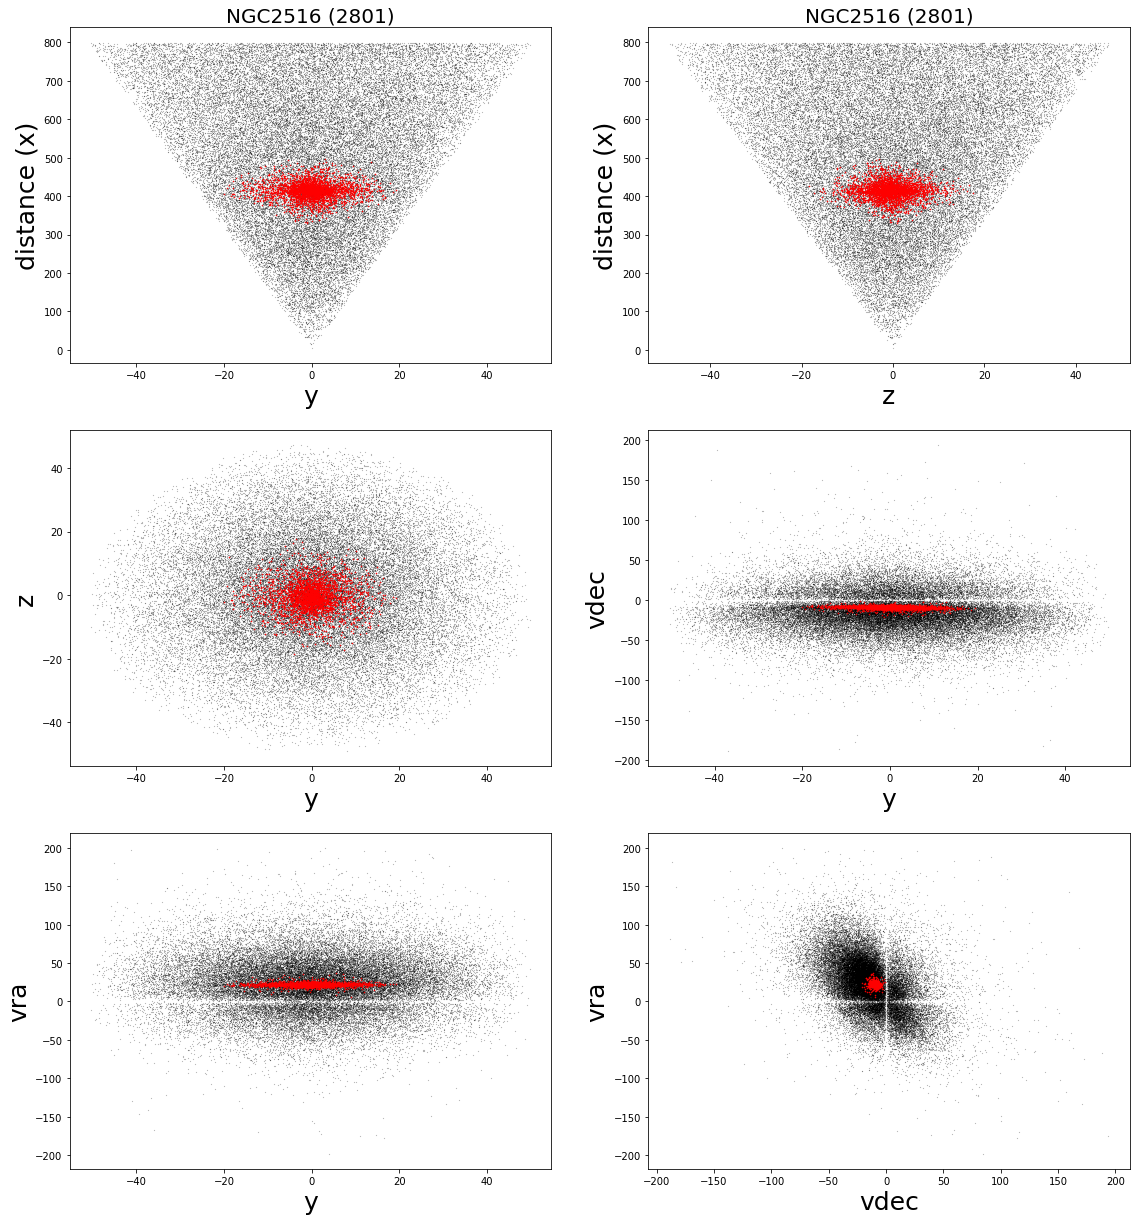

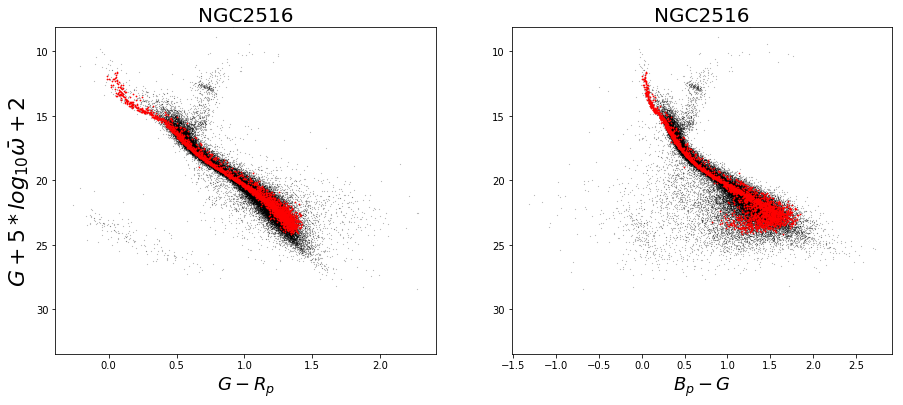

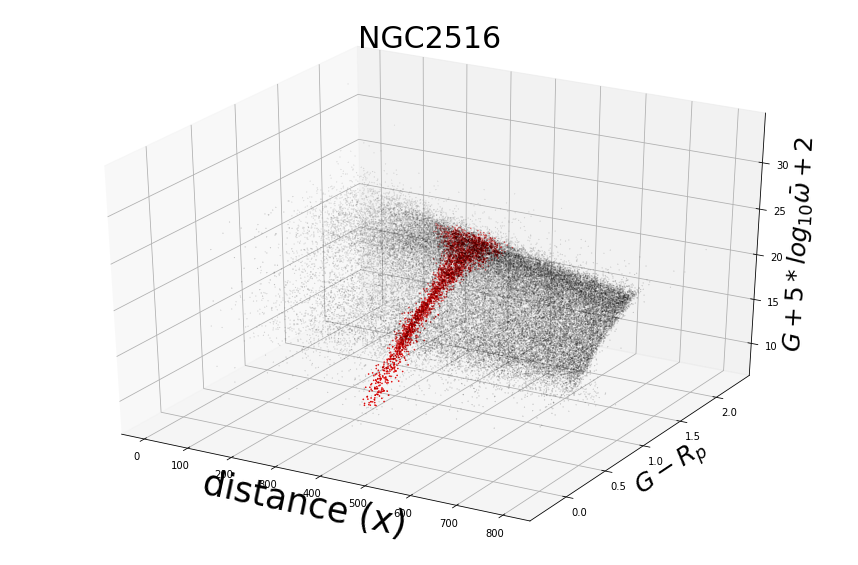

In [51]:
for ilabel in ilabel_ :
    #source.plot_information(0.1,False, HRD=False, ilabel=ilabel)
    source.plot_information(0.01,True, HRD=True, ilabel=ilabel)
    source.plot_3D(0.01,True,(0,6,5),ilabel=ilabel)

#### ------------------------------------------------------------------------
## Finding the best $eps$ and $min\_samples$

In [80]:
# #############################################################################
# Compute DBSCAN
data_to_compute = dfnormcart

ts = time.clock()
eps_ = [0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3]
min_samples_ = [10,15,20,25,30,40,50,60]
mat_nb_clusters = np.zeros((len(eps_),len(min_samples_)))
mat_max = np.zeros((len(eps_),len(min_samples_)))
for i in range(len(eps_)) :
    for j in range(len(min_samples_)) :
        db = DBSCAN(eps=eps_[i], min_samples=min_samples_[j]).fit(data_to_compute)
        labels = db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        mat_nb_clusters[i,j] = n_clusters_
        max_label = 0
        for n in range(n_clusters_) :
            ilabel = np.where(labels == n)[0]
            if len(ilabel) > max_label :
                max_label = len(ilabel)
                #max_label = len(ilabel)/np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])
        mat_max[i,j] = max_label
        #print("Ok pour eps "+str(eps_[i])+" et min_samples="+str(min_samples_[j]))
tf = time.clock() - ts
if tf//60 == 0 : string = "%.1fs"%(tf%60)
else : string = "%dmin %.1fs"%(tf//60,tf%60)
print("## Execution time : "+string)

## Execution time : 20.9s


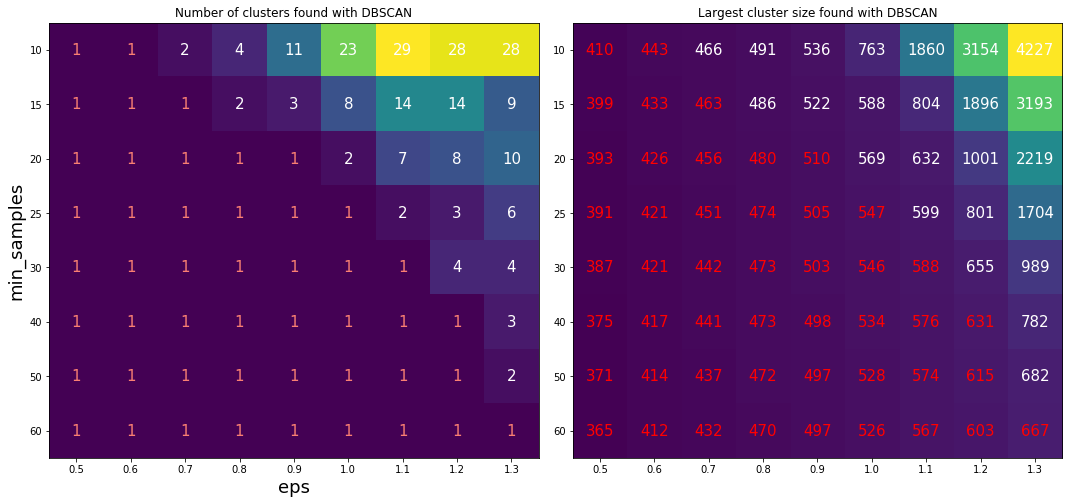

In [81]:
fig, (ax, ax2) = plt.subplots(1,2,figsize=(15,15))

im = ax.imshow(mat_nb_clusters.T)
ax.set_xticks(np.arange(len(eps_)))
ax.set_yticks(np.arange(len(min_samples_)))
ax.set_xticklabels(eps_)
ax.set_yticklabels(min_samples_)
# Loop over data dimensions and create text annotations.
for i in range(len(eps_)):
    for j in range(len(min_samples_)):
        if mat_nb_clusters[i, j] == 1 : color = "salmon"
        else : color = "w" 
        text = ax.text(i, j, '%d'%mat_nb_clusters[i, j],
                       ha="center", va="center", color=color, fontproperties='bold', fontsize=15)
ax.set_title("Number of clusters found with DBSCAN")
ax.set_xlabel("eps", fontsize = 18)
ax.set_ylabel("min_samples", fontsize = 18)
fig.tight_layout()

im = ax2.imshow(mat_max.T)
ax2.set_xticks(np.arange(len(eps_)))
ax2.set_yticks(np.arange(len(min_samples_)))
ax2.set_xticklabels(eps_)
ax2.set_yticklabels(min_samples_)
# Loop over data dimensions and create text annotations.
for i in range(len(eps_)):
    for j in range(len(min_samples_)):
        if mat_nb_clusters[i, j] == 1 : color = "r"
        else : color = "w" 
        text = ax2.text(i, j, '%d'%mat_max[i, j], ha="center", va="center", color=color, fontsize=15)
ax2.set_title("Largest cluster size found with DBSCAN")
ax.set_xlabel("eps", fontsize = 18)
ax.set_ylabel("min_samples", fontsize = 18)
fig.tight_layout()

plt.savefig('NGC6811_.png')
plt.show()

### -------------------------------------------------------------------------
# Finding the best $eps$

In [23]:
#source = tab_source[1]
# Cartesian normalisation
# x, y, z must have the same importance, the same for vdec and vra // R-G and 
dfnormcart = np.zeros(source.df.shape)

#weight  = [6*2000/source.distmax,2,2,4,4,4,4,4]
a = 2.025685069303716
weight_comp  = [0.03,0.2,0.25,2.]
weight_comp = np.array(weight_comp)*a/np.linalg.norm(weight_comp)

for i, j in zip(range(source.df.shape[1]),[0,0,0,1,1,2,3,3]) :
    dfnormcart[:,i] = weight_comp[j] * (source.dfcart[:,i] - np.mean(source.dfcart[:,i]))

In [15]:
tab_eps = np.linspace(0.5,0.85,40)
min_samples = 30
label_pre = []
result = []
ts = time.clock()

for eps in tab_eps :
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(dfnormcart)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    big_label = np.where(labels == 0)[0]
    for n in range(1,n_clusters) :
        ilabel = np.where(labels == n)[0]
        if len(ilabel) > len(big_label) :
            big_label = ilabel
       
    if len(label_pre) < len(big_label) :
        label_pre = big_label
        result.append((big_label,eps))
    
tf = time.clock() - ts
if tf//60 == 0 : string = "%.1fs"%(tf%60)
else : string = "%dmin %.1fs"%(tf//60,tf%60)
print(string)

31.3s


In [16]:
x = []; s = []; y0 = []
y = {}
for i in range(8) :
    y[i] = []
    
for label in result :
    x.append(label[1])
    #s.append(len(label[0]))
    s.append(np.sqrt(np.mean(np.linalg.norm(source.dfcart[label[0],:5] - np.mean(source.dfcart[label[0],:5],axis=0))**2))/len(label[0])**2)
    for i in range(8) :
        y[i].append(np.std(source.dfcart[label[0],i]))
    y0.append( np.sqrt(np.mean(np.linalg.norm(source.dfcart[label[0],:5] - np.mean(source.dfcart[label[0],:5],axis=0))**2)) )

NGC1912


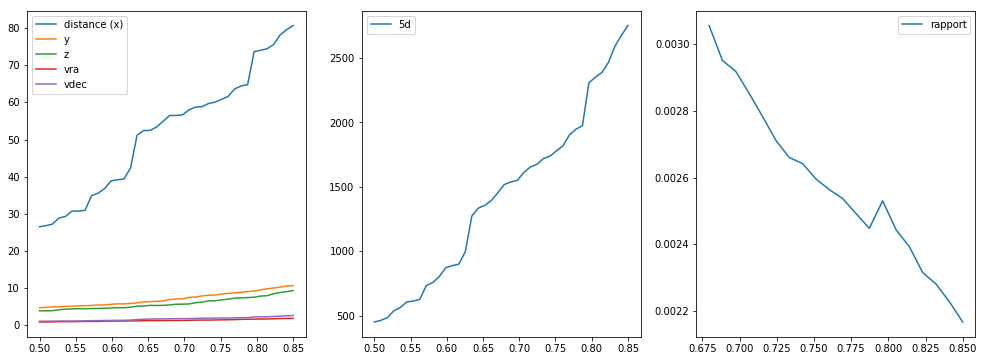

In [17]:
print(source.name)
plt.figure(figsize=(17,6))
plt.subplot(131)
for i in range(0,5) : 
    plt.plot(x,y[i],label=gu.data_name_cart[i])
plt.legend(loc=0)
plt.subplot(132)
plt.plot(x,y0,label='5d')
plt.legend(loc=0)
plt.subplot(133)
plt.plot(x[20:],s[20:],label='rapport')
plt.legend(loc=0)
plt.show()

0.500, 0.787


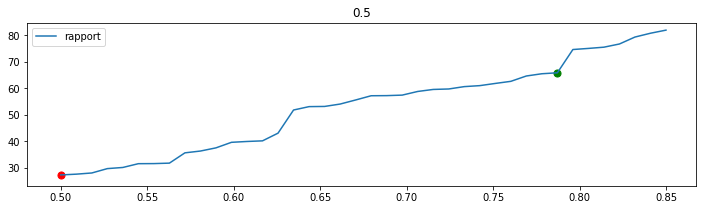

0.500, 0.626


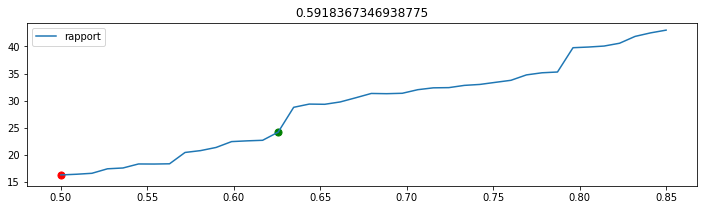

0.500, 0.626


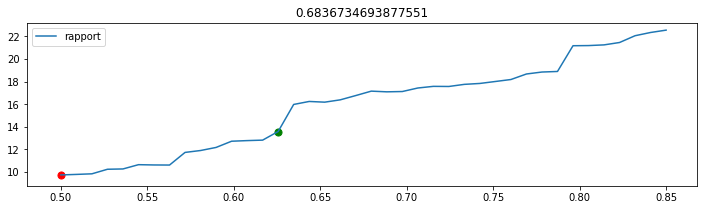

0.500, 0.626


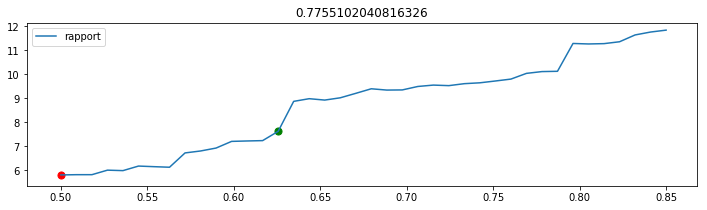

0.518, 0.626


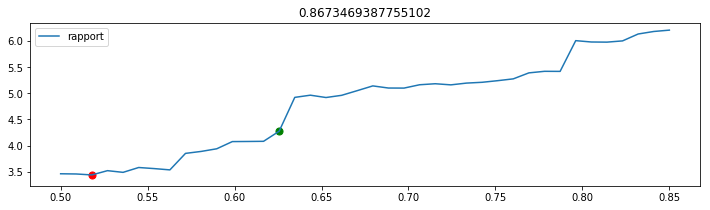

0.536, 0.626


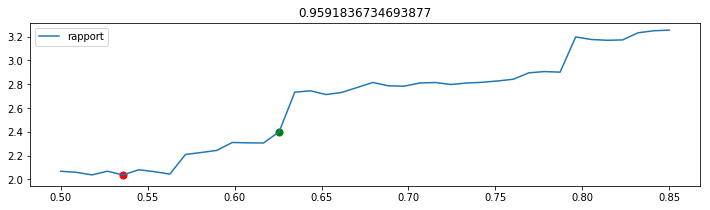

0.563, 0.626


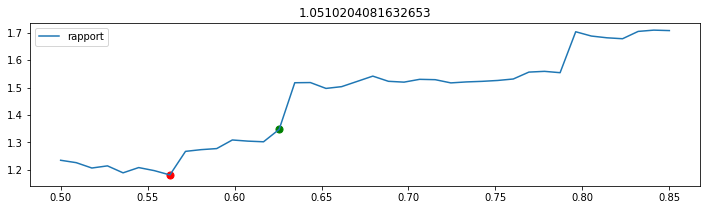

0.563, 0.626


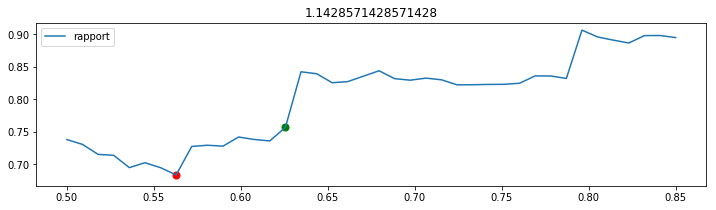

0.563, 0.626


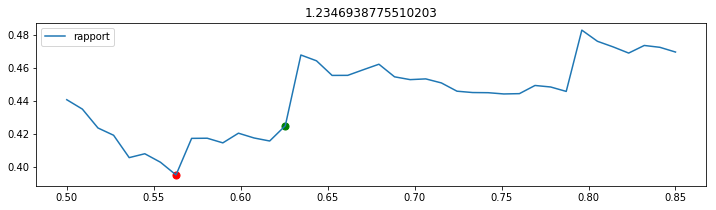

0.563, 0.626


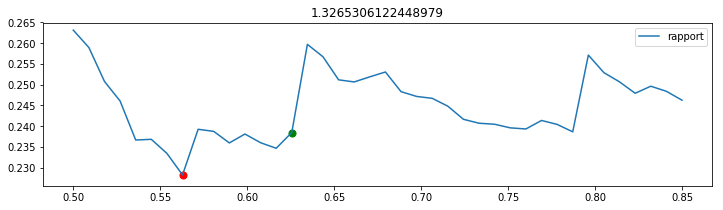

0.787, 0.626


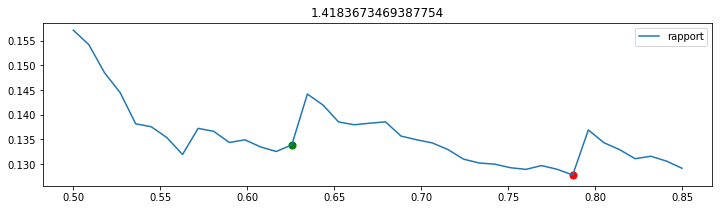

0.787, 0.626


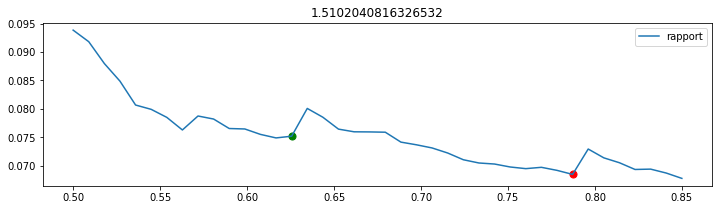

0.841, 0.626


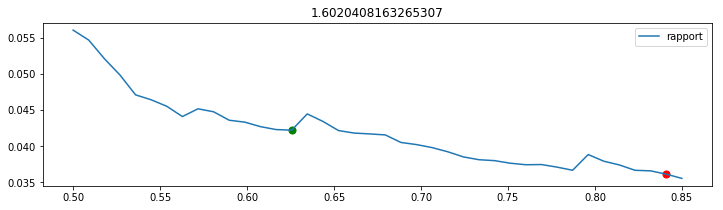

0.841, 0.787


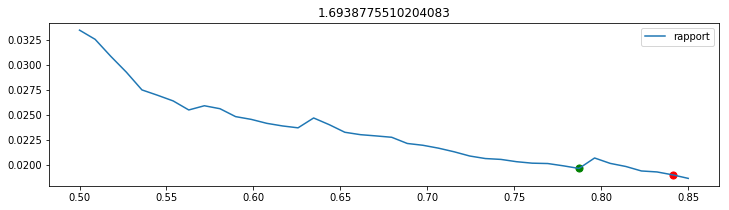

0.841, 0.787


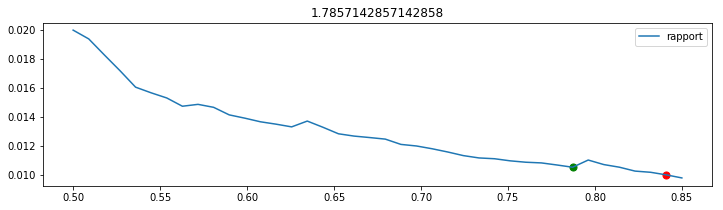

0.841, 0.787


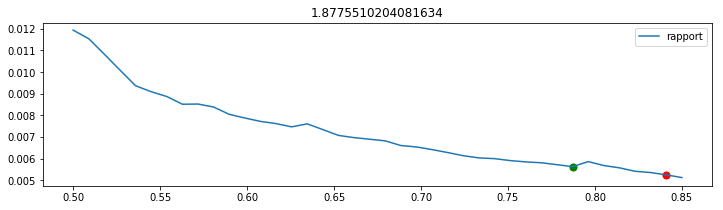

0.841, 0.787


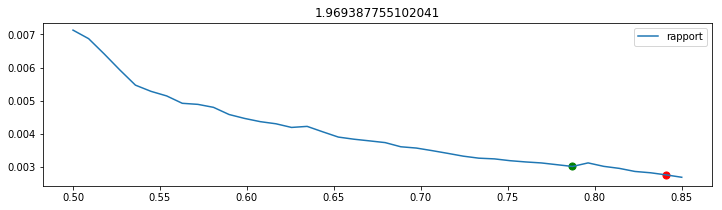

0.841, 0.787


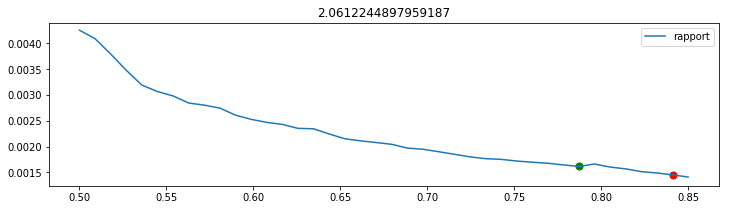

0.841, 0.787


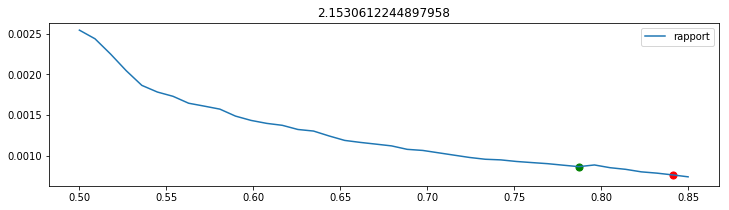

0.841, 0.787


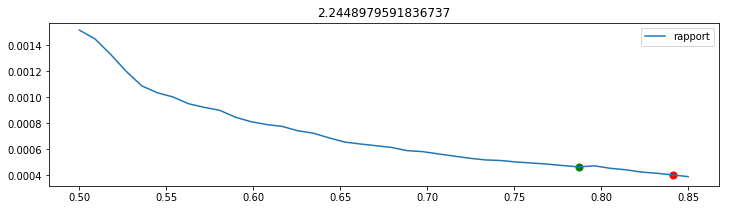

0.841, 0.787


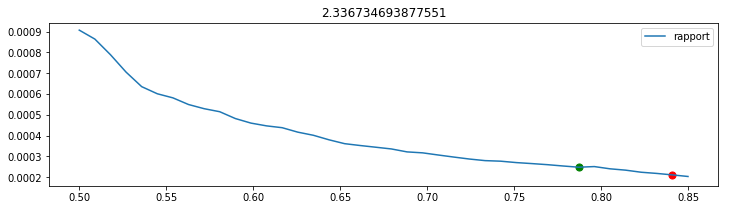

0.841, 0.787


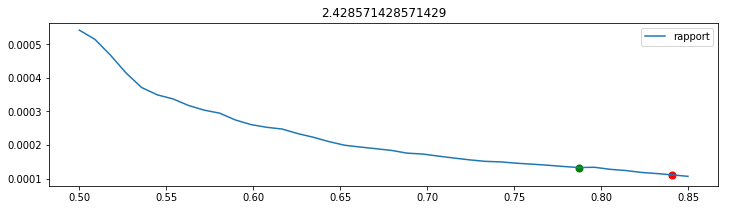

0.841, 0.787


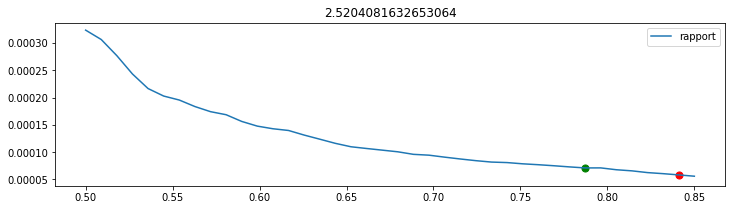

0.841, 0.787


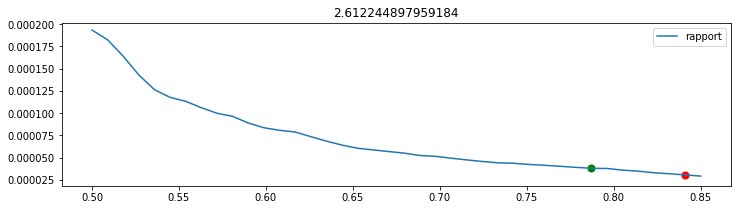

0.841, 0.787


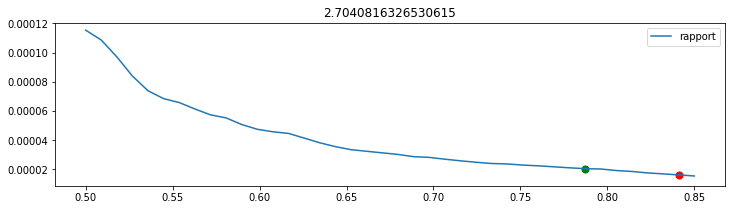

0.841, 0.787


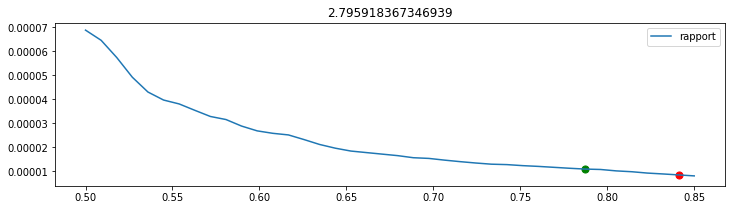

0.841, 0.733


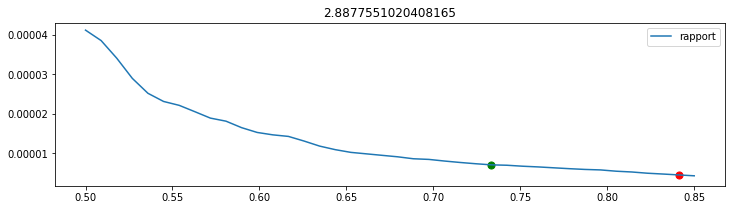

0.841, 0.733


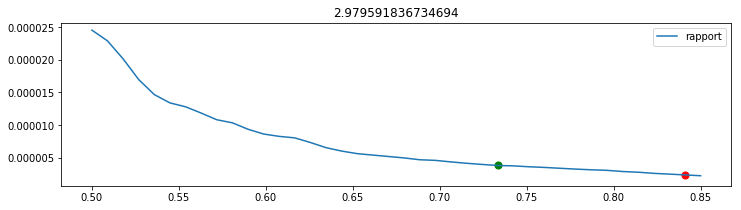

0.841, 0.733


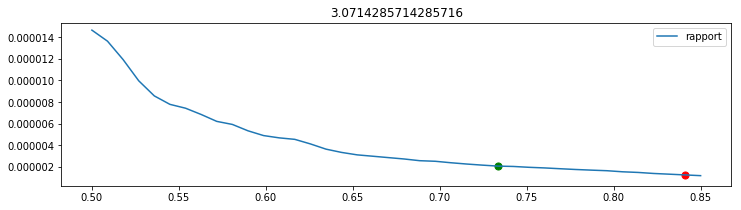

0.841, 0.733


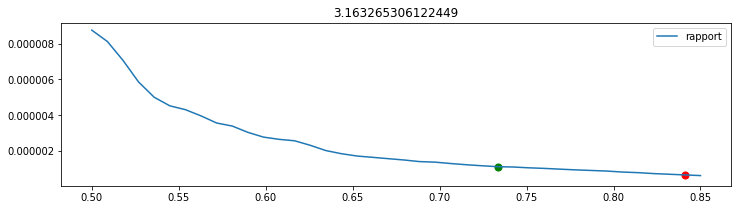

0.841, 0.733


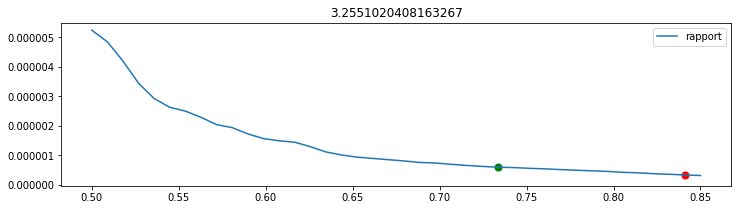

0.841, 0.733


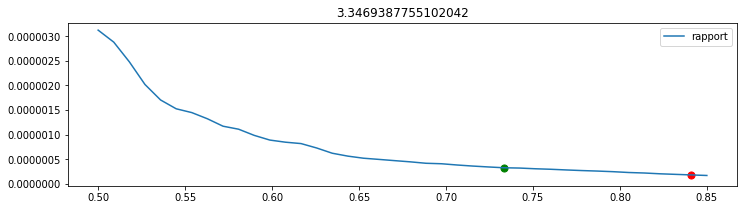

0.841, 0.733


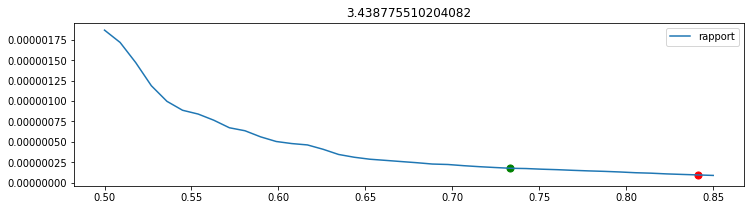

0.841, 0.733


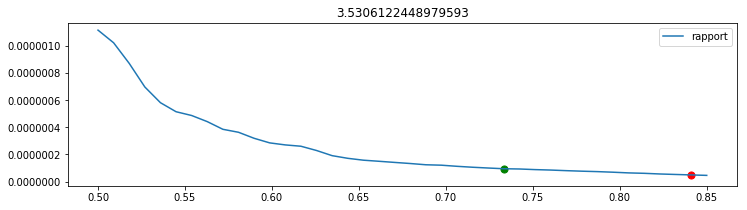

0.841, 0.733


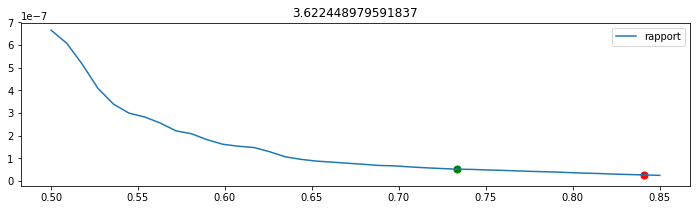

0.841, 0.733


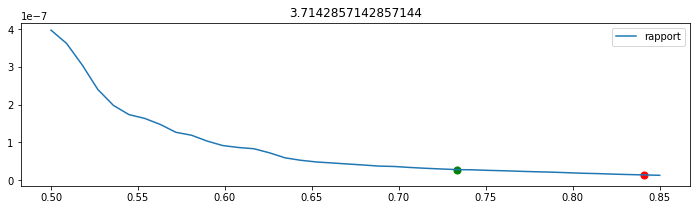

0.841, 0.733


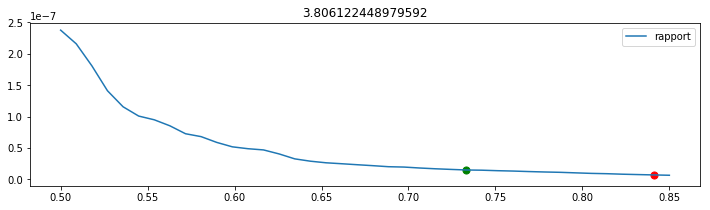

0.841, 0.733


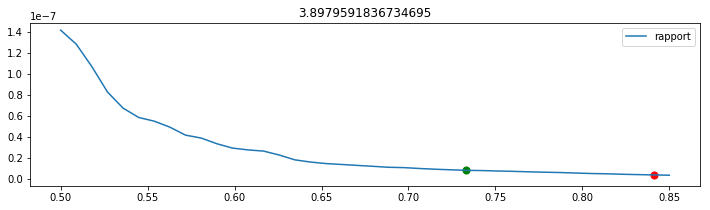

0.841, 0.733


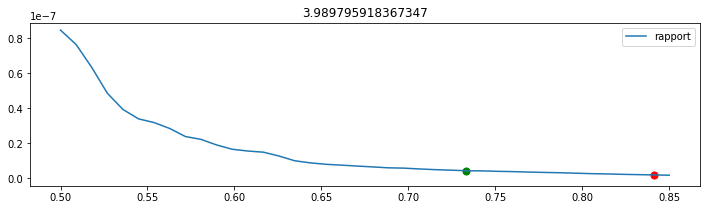

0.841, 0.733


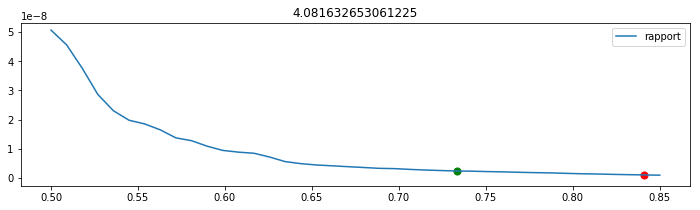

0.841, 0.733


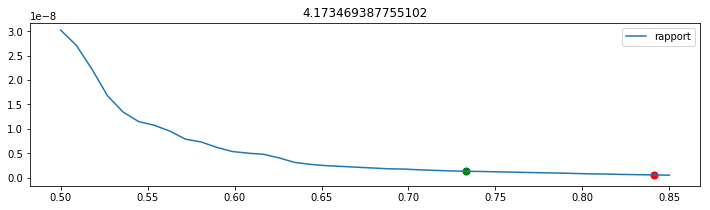

0.841, 0.733


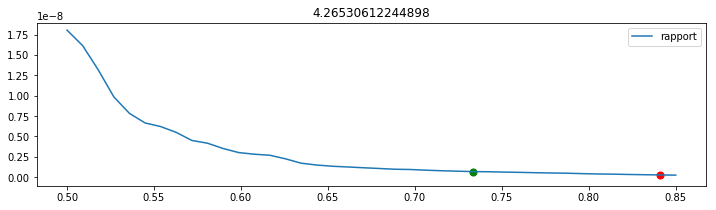

0.841, 0.733


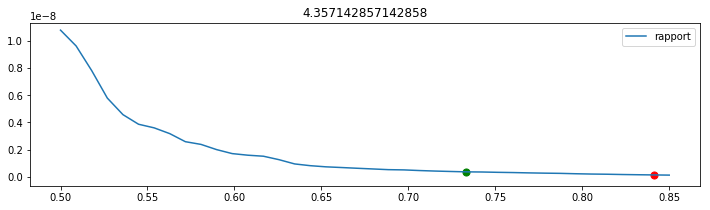

0.841, 0.733


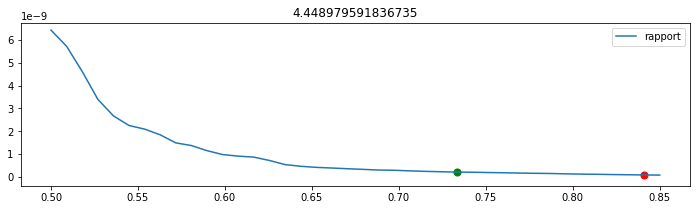

0.841, 0.733


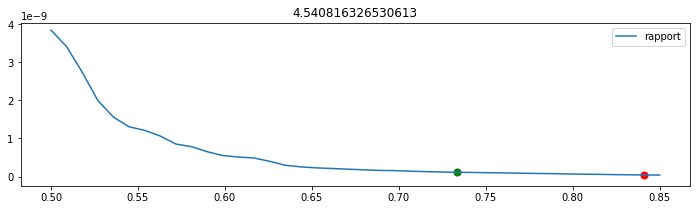

0.841, 0.733


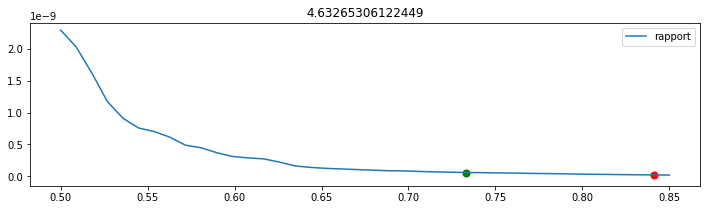

0.841, 0.733


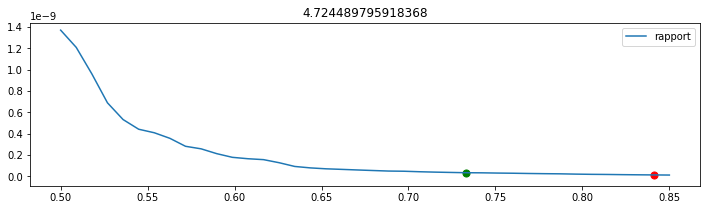

0.841, 0.733


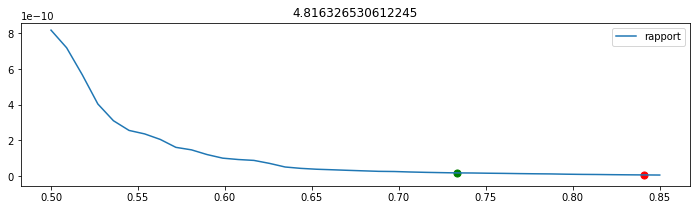

0.841, 0.733


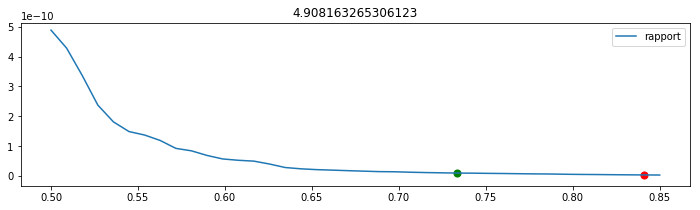

0.841, 0.733


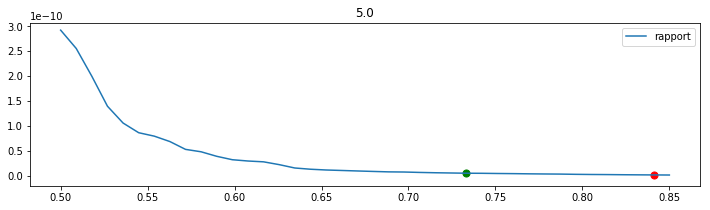

In [18]:
loc_min = []; loc_diff = []
exponant = np.linspace(0.5,5,50)
for exp in exponant :
#for exp in [2.0] :
    x = []; s = []
    for label in result :
        x.append(label[1])
        #s.append(len(label[0]))
        s.append(np.sqrt(np.mean(np.linalg.norm(source.dfcart[label[0],0:5] - np.mean(source.dfcart[label[0],0:5],axis=0))**2))/len(label[0])**exp)
    loc_min.append(x[np.argmin(s)])
    diff = np.argmax(np.array(s[1:])-np.array(s[:-1]))
    loc_diff.append(x[diff])
    print("%.3f, %.3f"%(x[np.argmin(s[0:-1])],x[diff]))
    plt.figure(figsize=(12,3))
    plt.plot(x[0:],s[0:],label='rapport')
    plt.scatter(x[np.argmin(s[0:-1])],min(s[0:-1]),c='r',s=50)
    plt.scatter(x[diff],s[diff],c='g',s=50)
    plt.legend(loc=0)
    plt.title(exp)
    plt.show()

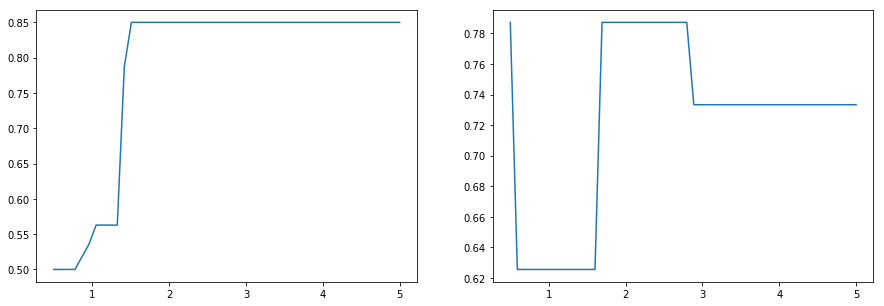

In [19]:
plt.figure(figsize=(15,5)); plt.subplot(121)
plt.plot(exponant,loc_min)
plt.subplot(122)
plt.plot(exponant,loc_diff)
plt.show()

## -----------------------------------------------------------
## Clustering with normalization depending on the average distance

In [11]:
a = []
for i in range(8) :
    dist = np.sort(source.dfcart[:,i])
    distm = dist[1:] - dist[:-1]
    a.append(np.mean(distm))
a = np.array(a)
print(a*1000)
print(1/a)
div = [15,8,0.5,0.07]

[24.95616913  5.36191234  5.08807269 14.72495923 16.33957355  0.99576171
  0.11059028  0.14162818]
[  40.07025255  186.50062455  196.53807253   67.91190281   61.20110765
 1004.25632861 9042.38589553 7060.74172254]


In [22]:
def lissage(x,y,p):
    "smoothing y data computing the Moving average"
    Lyout=[]; Lxout = np.copy(x[p: -p])
    for index in range(p, len(y)-p):
        Lyout.append(np.mean(y[index-p : index+p+1]))
    return Lxout,Lyout

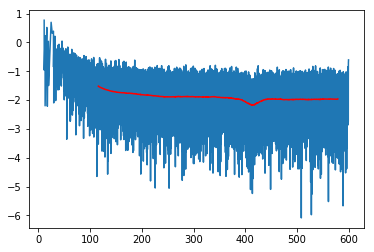

0.024956169134300637


In [13]:
dist = np.sort(source.dfcart[:,0])
distm = dist[1:] - dist[:-1]  
x, y = lissage(dist[1:],np.log10(distm), 1000)
plt.plot(dist[1:],np.log10(distm))
plt.plot(x,y,c='r')
plt.show()
print(np.mean(distm))

## ------------------------------------------------------------
### Loop to get all votable in the list

In [41]:
voname_list = ["NGC2682-4.0deg-0.2err.vot","NGC2516-6.0deg-0.2err.vot","NGC1647-4.0deg-0.2err.vot",
               "NGC1912-2.0deg-0.2err.vot","NGC2632-8.0deg-0.2err.vot", "NGC1647-4.0deg-0.2err.vot"]

#voname_list = ["NGC2516-6.0deg-0.01err.vot", "NGC2516-6.0deg-0.02err.vot",
#               "NGC2516-6.0deg-0.03err.vot","NGC2516-6.0deg-0.2err.vot", "NGC2682-4.0deg-0.2err.vot"]
#tab_source = []
for voname in ["NGC1746-1.5deg-0.4err.vot"] :
    source = gu.source()
    source.read_votable(voname)
    source.convert_filter_data()
    source.convert_to_cartesian()
    tab_source.append(source)

## NGC1746-1.5deg-0.4err.vot read...
#  Total stars: 16652
#  Density star per pc^3: 0.01742

#  Conversion on 16652 stars done...
#  Stars selected: 12542



In [4]:
for source in tab_source :
    print("%s_%serr"%(source.name,source.errtol))

NGC2682_0.2err
NGC2516_0.2err
NGC1647_0.2err
NGC1912_0.2err
NGC2632_0.2err
NGC1647_0.2err


## -------------------------------------------------------------------
## Weight and cartesian clustering

In [14]:
a = []
for i in range(8) :
    dist = np.sort(source.dfcart[:,i])
    distm = dist[1:] - dist[:-1]
    a.append(np.mean(distm))
a = np.array(a)
print(a*10000)
b =[]
for i, j in zip(range(8),[0,0,0,1,1,2,3,3]) :
    b.append(a[i]*weight_comp[j]*10000)
print(b)

[75.48450033 16.41927111 15.76036564 48.37125212 50.43037836  3.20797011
  0.3360726   0.78963304]
[2.264535009857655, 0.49257813339339995, 0.47281096916872356, 9.67425042462723, 10.086075672326187, 0.8019925276878547, 0.6721451937372273, 1.5792660740977658]


In [186]:
source = tab_source[0]
for source in tab_source :
    # Cartesian normalisation
    # x, y, z must have the same importance, the same for vdec and vra // R-G and 
    dfnormcart = np.zeros(source.df.shape)
    print("%s_%serr"%(source.name,source.errtol))
    #weight  = [6*2000/source.distmax,2,2,4,4,4,4,4]
    a = 2.025685069303716
    #weight_comp  = [0.03,0.2,0.25,2.]
    weight_comp  = [0.03,0.15,0.25,2.]
    #weight_comp = np.array(weight_comp)*a/np.linalg.norm(weight_comp)

    for i, j in zip(range(source.df.shape[1]),[0,0,0,1,1,2,3,3]) :
        dfnormcart[:,i] = weight_comp[j] * (source.dfcart[:,i] - np.mean(source.dfcart[:,i]))

    a = []
    for i in range(8) :
        dist = np.sort(dfnormcart[:,i])
        distm = dist[1:] - dist[:-1]
        a.append(np.mean(distm))
    a = np.array(a)
    rap = 2*a[0]/(a[1]+a[2])
    print(np.around(a*1000,2),": %.2f"%rap)

NGC2516_0.01err
[1.57 0.34 0.31 4.18 4.75 0.5  0.42 0.57] : 4.81
NGC2516_0.02err
[0.75 0.16 0.15 2.21 2.45 0.25 0.22 0.28] : 4.78
NGC2516_0.03err
[0.58 0.12 0.12 1.74 1.91 0.2  0.17 0.26] : 4.76
NGC2516_0.2err
[0.23 0.05 0.05 0.73 0.76 0.08 0.07 0.16] : 4.69
NGC2682_0.2err
[0.84 0.14 0.11 1.18 0.91 0.11 0.11 0.19] : 6.71


# --------------------------------------------------------------

In [42]:
source = tab_source[-1]
# Cartesian normalisation
# x, y, z must have the same importance, the same for vdec and vra // R-G and 
dfnormcart = np.zeros(source.df.shape)

#weight  = [6*2000/source.distmax,2,2,4,4,4,4,4]
a = 2.025685069303716
#weight_comp  = [0.03,0.2,0.25,2.]
weight_comp  = [0.03,0.15,0.25,2.]
#weight_comp = np.array(weight_comp)*a/np.linalg.norm(weight_comp)

for i, j in zip(range(source.df.shape[1]),[0,0,0,1,1,2,3,3]) :
    dfnormcart[:,i] = weight_comp[j] * (source.dfcart[:,i] - np.mean(source.dfcart[:,i]))

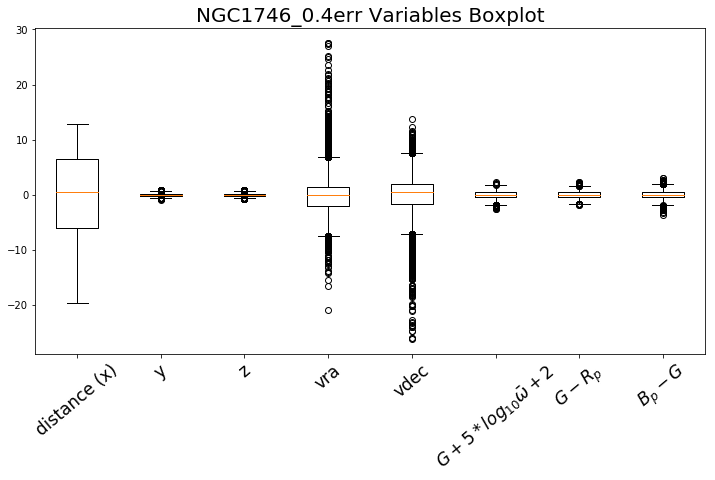

In [43]:
plt.figure(figsize=(12,6))
plt.title("%s_%serr Variables Boxplot"%(source.name,source.errtol), fontsize=20)
plt.boxplot(dfnormcart)
plt.xticks(np.arange(len(gu.data_name_cart))+1, gu.data_name_cart, rotation = 40, fontsize = 17)
plt.show()

In [44]:
eps=0.9
min_samples=30
#source = tab_source[2]
ilabel_ = gu.dbscan_labels(dfnormcart,eps, min_samples, all_labels=True, display=True)
#save_ilabel(source, ilabel_[0], eps, min_samples, weight_comp)
#print("## %d, %d stars, Dist : %.1f, Max Dist : %.1f and %.1f"%(i,len(ilabel),np.mean(source.df[ilabel,0]),
#    np.max(source.df[ilabel,0])-np.min(source.df[ilabel,0]),np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])))

## 2 clusters, size of the largest: 428  (on 12542 stars : 3.4%)
## Execution time : 0.3s


In [45]:
for i, ilabel in enumerate(ilabel_):
    #a = np.zeros(source.df.shape[0])
    #a[ilabel] = 1
    #ii = np.where(a==0)[0]
    #gu.plot_information_cluster(source.dfcart[ii,:],size=0.01,cartesian=True)
    #gu.plot_information_cluster(source.dfcart,size=0.01,cartesian=True)
    print("## %d, %d stars, Dist : %.1f, Max Dist : %.1f and %.1f"%(i,len(ilabel),np.mean(source.df[ilabel,0]),
    np.max(source.df[ilabel,0])-np.min(source.df[ilabel,0]),np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])))

## 0, 428 stars, Dist : 733.9, Max Dist : 177.7 and 36.4
## 1, 321 stars, Dist : 905.2, Max Dist : 198.3 and 45.7


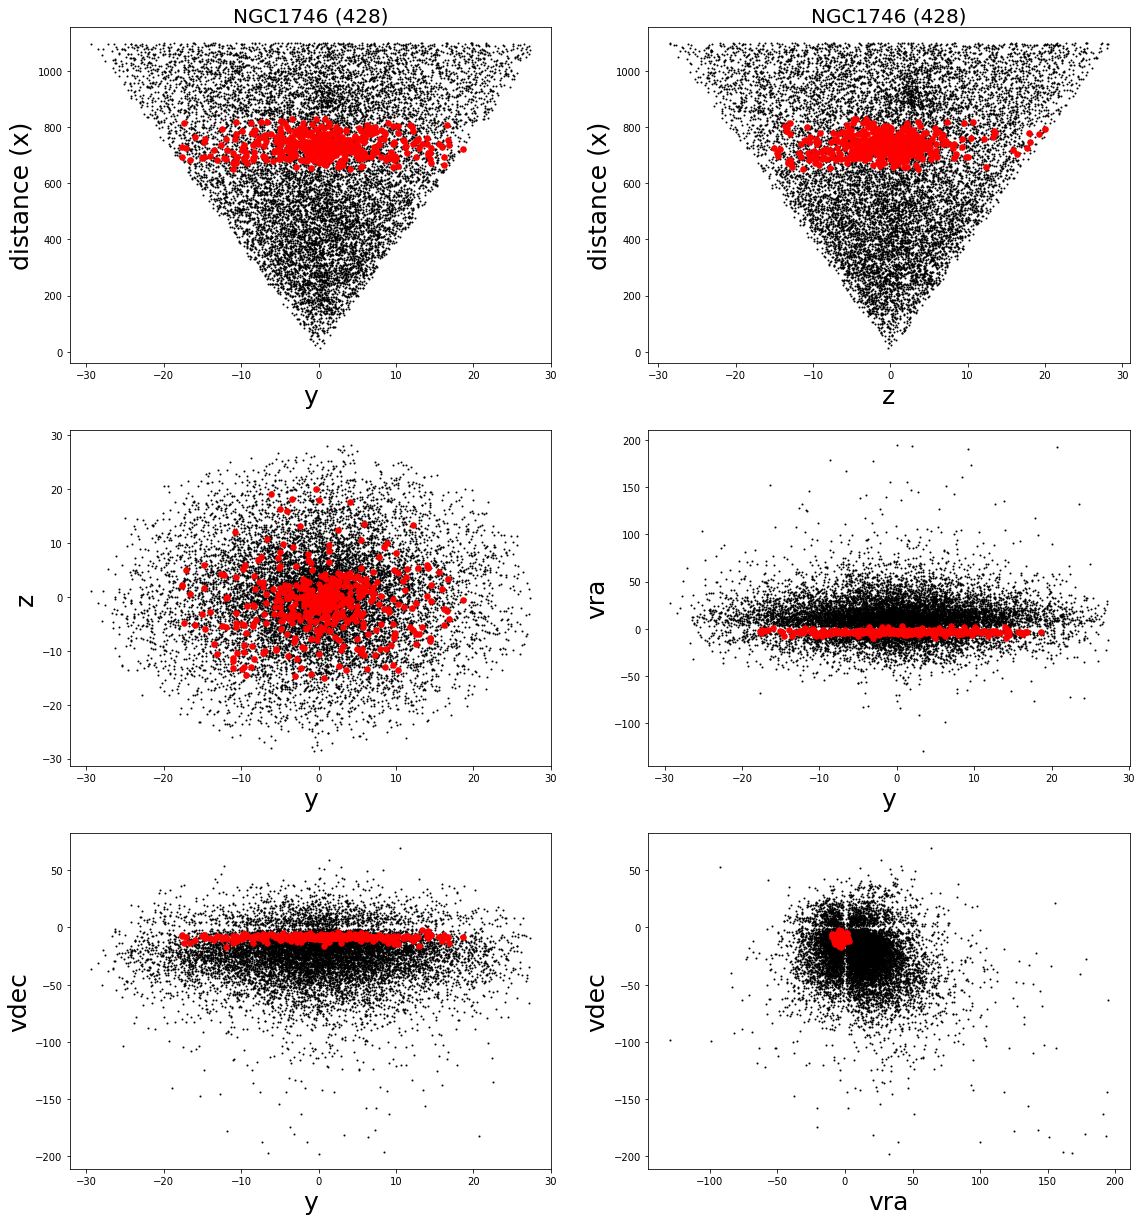

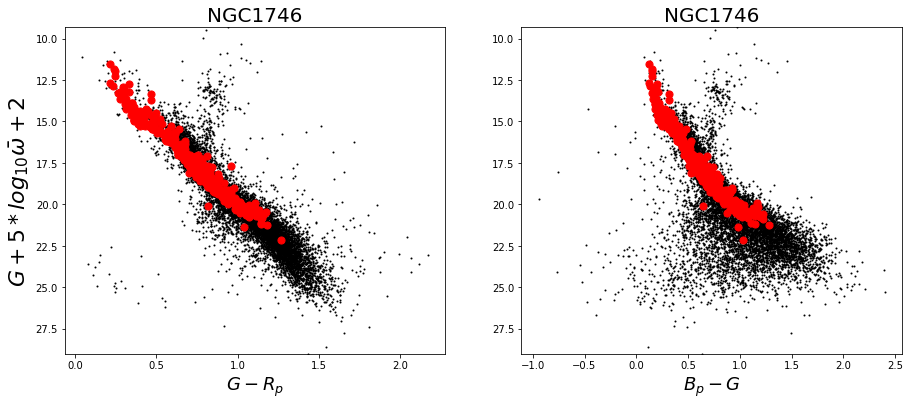

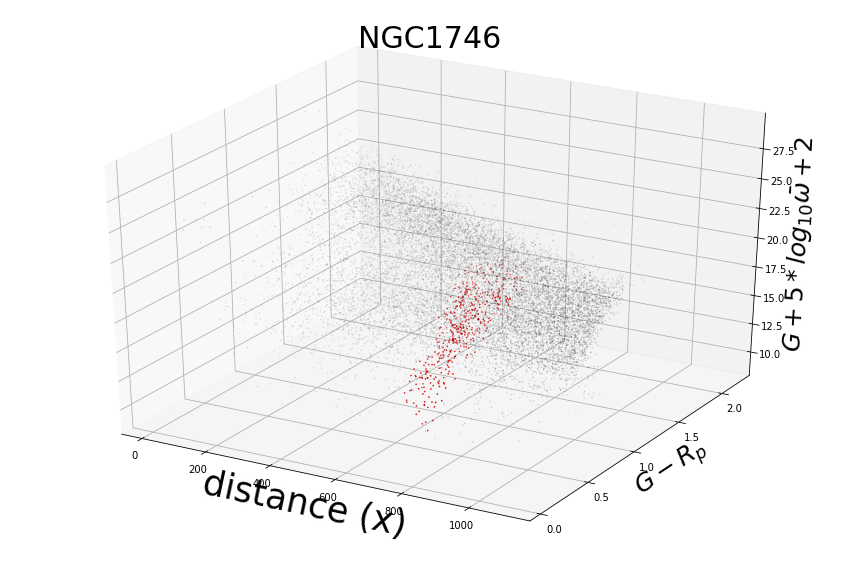

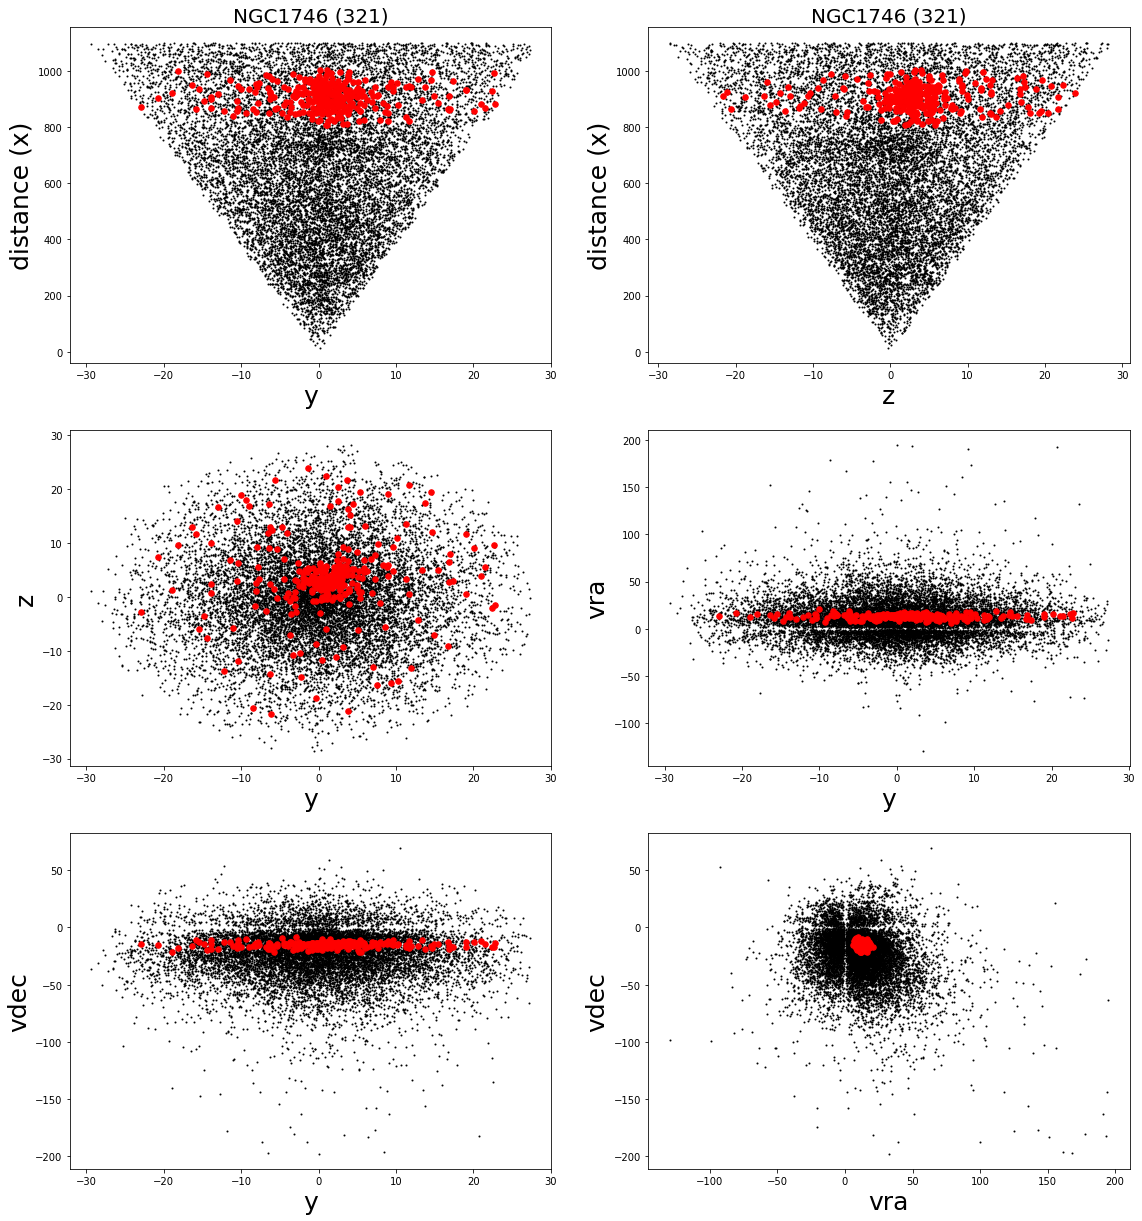

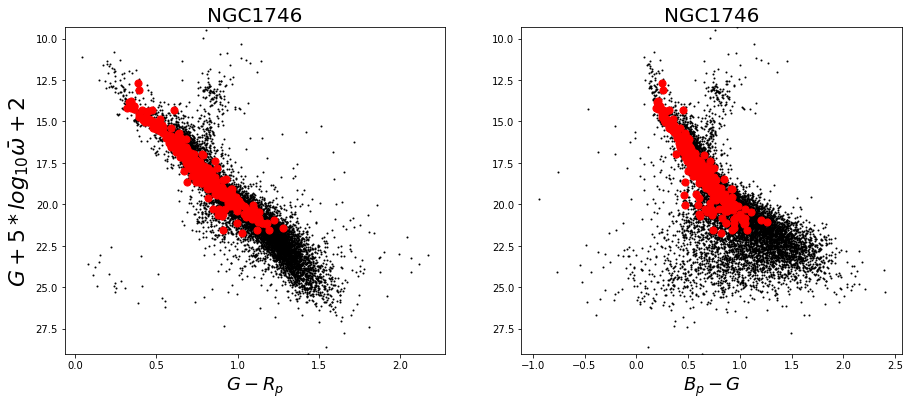

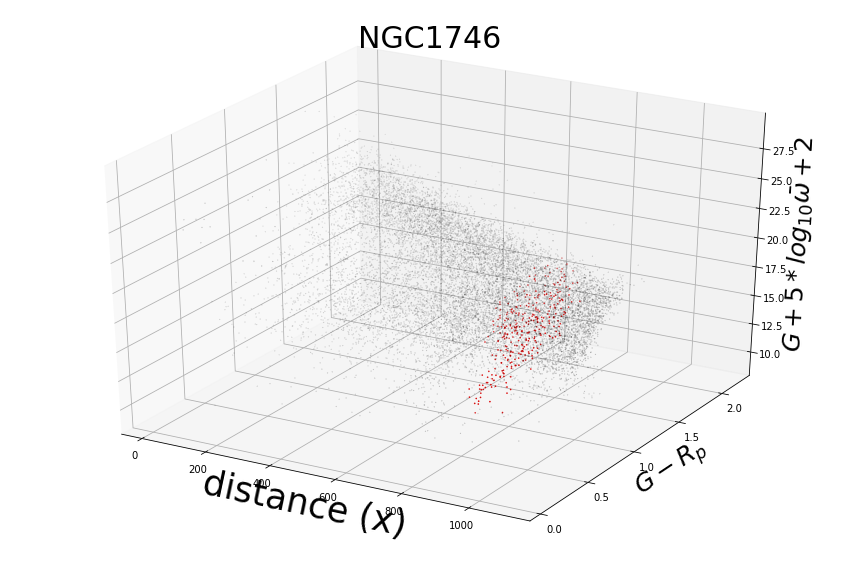

In [46]:
for ilabel in ilabel_ :
    #source.plot_information(0.1,False, HRD=False, ilabel=ilabel)
    source.plot_information(1.01,True, HRD=True, ilabel=ilabel)
    source.plot_3D(0.01,True,(0,6,5),ilabel=ilabel)

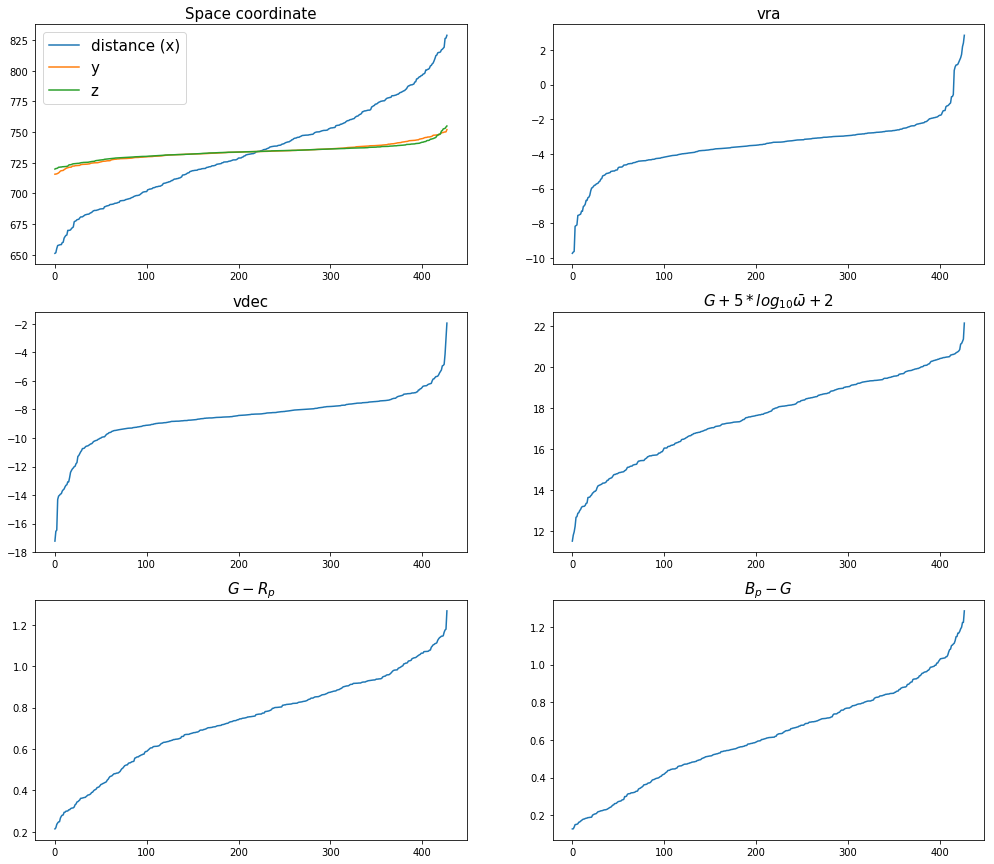

38.459437630869985
6.631938178153775
5.670880033359403
1.5494827194320895
1.7191338302309598
2.0817598665115318
0.22197989507386806
0.2565559816629823


In [47]:
#print(np.std(source.dfcart[:,0]))
ilabel = ilabel_[0]
plt.figure(figsize=(17,15))
plt.subplot(321)
plt.title("Space coordinate", fontsize=15)
for i in range(3) :
    #plt.subplot(3,2,i+1)
    plt.plot(np.sort(source.dfcart[ilabel,i])-np.mean(source.dfcart[ilabel,i])+np.mean(source.dfcart[ilabel,0]), label=gu.data_name_cart[i])
    #plt.plot(np.zeros(len(np.sort(source.df[ilabel,3]))),c='r')
plt.legend(loc='best',fontsize=15)
for i in range(3,8) :
    plt.subplot(3,2,i-1)
    plt.title(gu.data_name_cart[i], fontsize=15)
    plt.plot(np.sort(source.dfcart[ilabel,i]))
plt.show()
for i in range(8) :
    print(np.std(source.dfcart[ilabel,i]))

### ---------------------------------------------------------
# Ok loop

## 1 clusters, size of the largest: 1047  (on 45802 stars : 2.3%)
## Execution time : 2.9s
## 0, 1047 stars, Dist : 876.7, Max Dist : 200.9 and 51.7


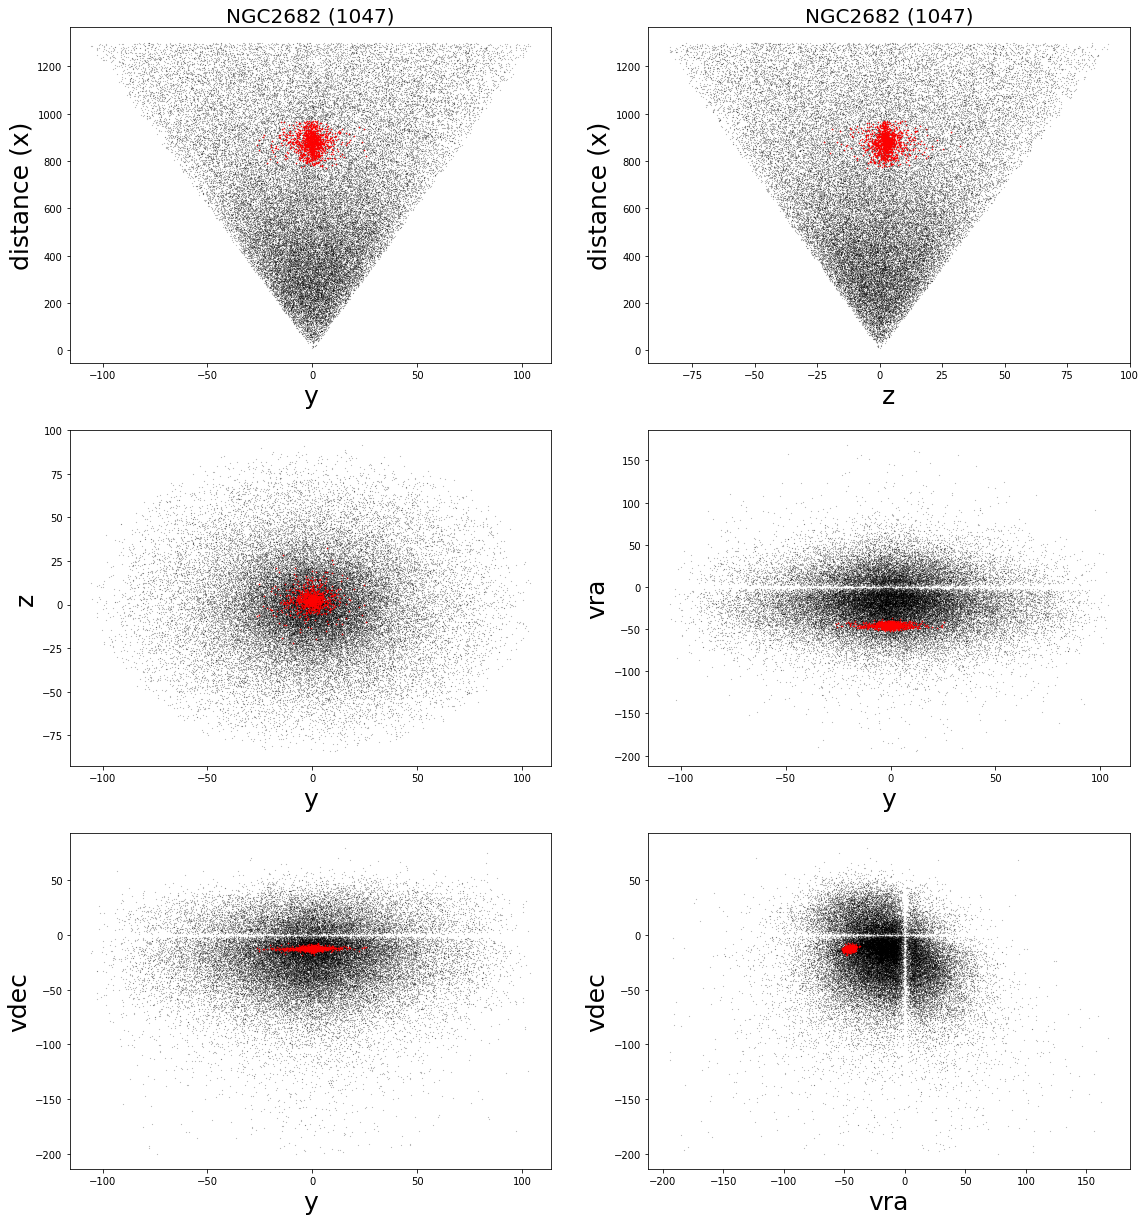

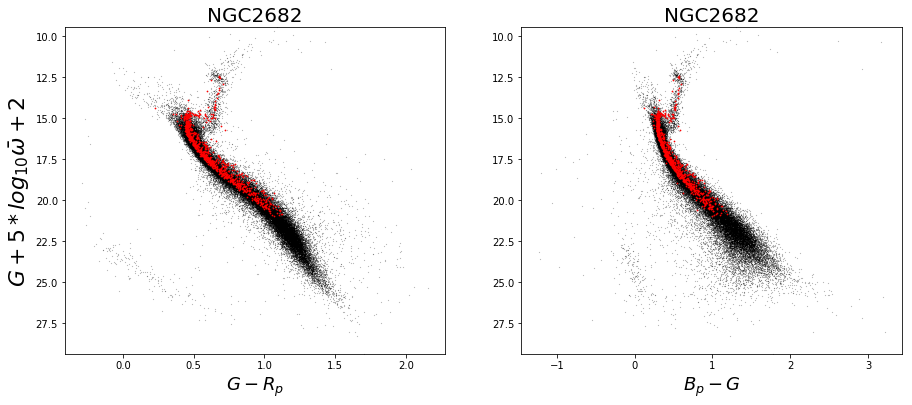

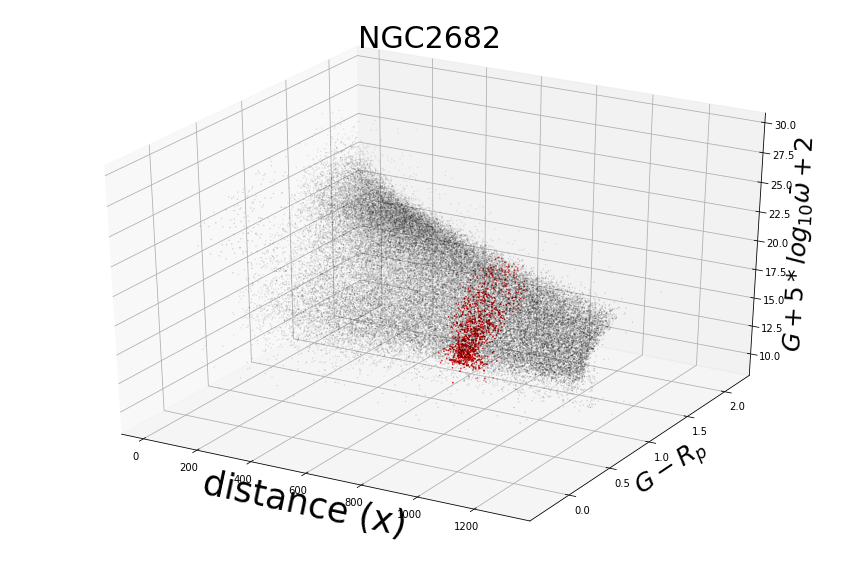

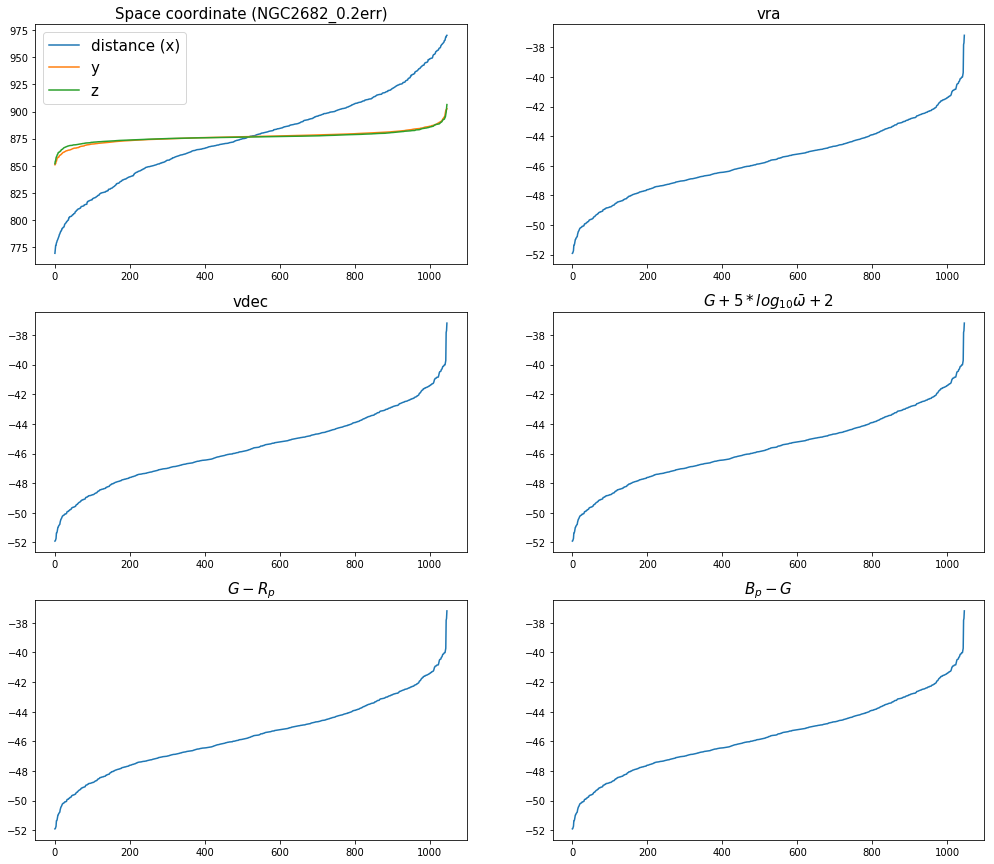

40.85117875549707
5.933502584247448
4.9852933603060325
2.393372525792203
1.212016482295326
1.6827411699665076
0.17650851597861697
0.20875496522362322


In [107]:
source = tab_source[0]
#for source in tab_source :
# Cartesian normalisation
# x, y, z must have the same importance, the same for vdec and vra // R-G and 
dfnormcart = np.zeros(source.df.shape)

#weight  = [6*2000/source.distmax,2,2,4,4,4,4,4]
weight_comp  = [0.03,0.2,0.25,2.]

for i, j in zip(range(source.df.shape[1]),[0,0,0,1,1,2,3,3]) :
    dfnormcart[:,i] = weight_comp[j] * (source.dfcart[:,i] - np.mean(source.dfcart[:,i]))

eps=0.73
min_samples=30
#source = tab_source[2]
ilabel_ = gu.dbscan_labels(dfnormcart,eps, min_samples, all_labels=True, display=True)
#save_ilabel(source, ilabel, eps, min_samples)
#print("## %d, %d stars, Dist : %.1f, Max Dist : %.1f and %.1f"%(i,len(ilabel),np.mean(source.df[ilabel,0]),
#    np.max(source.df[ilabel,0])-np.min(source.df[ilabel,0]),np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])))

for i, ilabel in enumerate(ilabel_):
    #a = np.zeros(source.df.shape[0])
    #a[ilabel] = 1
    #ii = np.where(a==0)[0]
    #gu.plot_information_cluster(source.dfcart[ii,:],size=0.01,cartesian=True)
    #gu.plot_information_cluster(source.dfcart,size=0.01,cartesian=True)
    print("## %d, %d stars, Dist : %.1f, Max Dist : %.1f and %.1f"%(i,len(ilabel),np.mean(source.df[ilabel,0]),
    np.max(source.df[ilabel,0])-np.min(source.df[ilabel,0]),np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])))

for ilabel in ilabel_ :
    #source.plot_information(0.1,False, HRD=False, ilabel=ilabel)
    source.plot_information(0.01,True, HRD=True, ilabel=ilabel)
    source.plot_3D(0.01,True,(0,6,5),ilabel=ilabel)

ilabel = ilabel_[0]
plt.figure(figsize=(17,15))
plt.subplot(321)
plt.title("Space coordinate (%s_%serr)"%(source.name,source.errtol), fontsize=15)
for i in range(3) :
    #plt.subplot(3,2,i+1)
    plt.plot(np.sort(source.dfcart[ilabel,i])-np.mean(source.dfcart[ilabel,i])+np.mean(source.dfcart[ilabel,0]), label=gu.data_name_cart[i])
    #plt.plot(np.zeros(len(np.sort(source.df[ilabel,3]))),c='r')
plt.legend(loc='best',fontsize=15)
for i in range(3,8) :
    plt.subplot(3,2,i-1)
    plt.title(gu.data_name_cart[i], fontsize=15)
    plt.plot(np.sort(source.df[ilabel,3]))
plt.show()
for i in range(8) :
    print(np.std(source.dfcart[ilabel,i]))

# --------------------------------------------------------------------

In [44]:
def lissage2(x,y,p):
    "smoothing y data computing the Moving average"
    Lyout=[]; Lxout = np.copy(x[p: -p])
    for index in range(p, len(y)-p):
        Lyout.append(np.mean(y[index-p : index+p+1]))
    return Lxout,Lyout

0.09498086414227387 -11.363498167089409


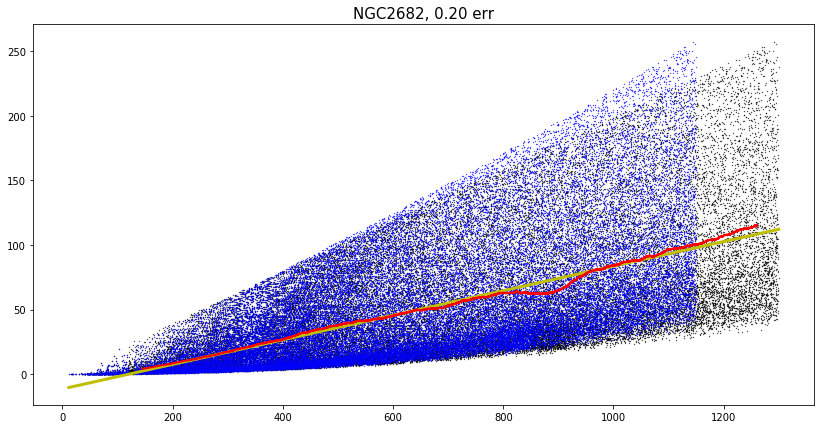

In [91]:
source = tab_source[0]
ifinal = source.unmasked
parallax_err = np.array(source.data['parallax_error'][ifinal])
dist = source.dfcart[:,0]
dist_err = dist**2 * parallax_err / 1000

a = []
for i in range(len(dist)) :
    a.append([dist[i],dist_err[i]])
a = np.array(sorted(a))

x_m, y_m = lissage(a[:,0],a[:,1], 1000)

x = a[:,0]
y = a[:,1]

A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
print(m,c)

plt.figure(figsize=(14,7))
plt.plot(x, m*x + c, 'y', linewidth=3, label='Fitted line')

plt.title("%s, %.2f err"%(source.name,source.errtol),fontsize=15)
plt.scatter(dist,dist_err,c='k',s=0.1)
plt.plot(np.array(x_m),np.array(y_m), linewidth=2, c='r')


for i in range(len(x)) :
    if x[i] > -c/m :
        x[i] = x[i] - (m*x[i]**2/1000+c)

plt.title("%s, %.2f err"%(source.name,source.errtol),fontsize=15)
plt.scatter(x,y,c='b',s=0.1)


plt.show()

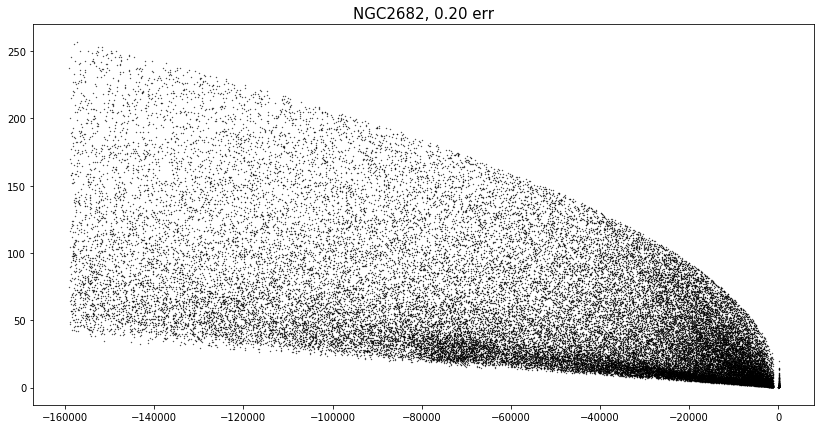

In [88]:
for i in range(len(x)) :
    if x[i] > -c/m :
        x[i] = x[i] - (5*m*x[i]+c)

plt.figure(figsize=(14,7))
plt.title("%s, %.2f err"%(source.name,source.errtol),fontsize=15)
plt.scatter(x,y,c='k',s=0.1)
plt.show()

693.9047413720112
NGC2682_0.2 : 9.14
NGC2516_0.2 : 3.77
NGC1647_0.2 : 3.55


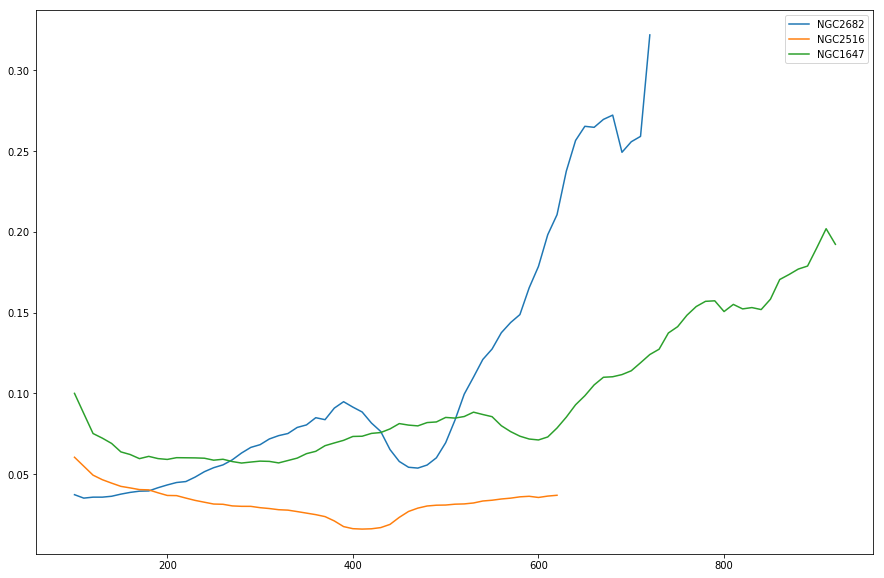

In [75]:
#source = tab_source[1]
a = 2/2250000
plt.figure(figsize=(15,10))
for source in tab_source[:-4] :
    data = np.copy(source.dfcart)
    
    if source.name == "NGC2682" : 
        ifinal = source.unmasked
        parallax_err = np.array(source.data['parallax_error'][ifinal])
        dist_err = data[:,0]**2 * parallax_err / 1000
        A = np.vstack([data[:,0], np.ones(len(data[:,0]))]).T
        m, c = np.linalg.lstsq(A, dist_err, rcond=None)[0]
        for i in range(len(data[:,0])) :
            if data[i,0] > -c/m :
                data[i,0] = data[i,0] - (5*m*data[i,0]+c)
            
        print(max(data[:,0]))
        
    step = np.arange(100,1000,10)
    a = []
    for i in step :
        c = 0.02*i
        c = 0
        ilab = np.where((data[:,0]<i+30) & (data[:,0]>i-30) & (data[:,1]<c+6) & (data[:,1]>c-6))[0]
        dist = np.sort(data[ilab,0])
        #print("%.4f"%np.mean(dist[1:] - dist[:-1]))
        a.append(np.mean(dist[1:] - dist[:-1]))
    plt.plot(step,a,label=source.name)
    print("%s_%s : %.2f"%(source.name,source.errtol,max(a)/min(a)))
plt.legend(loc=0)
plt.show()

[ 62.5         68.18181818 102.27272727 187.5        255.68181818]


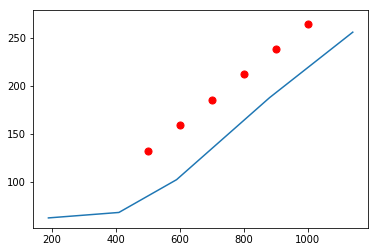

0.26
68


In [108]:
a = np.array([1.1,1.2,1.8,3.3,4.5])
pos = np.array([190,410,590,880,1140])
dim = a*1000/17.6
print(dim)
plt.plot(pos,dim)
coeff = (max(dim)-min(dim))/(max(pos)-min(pos[1:]))
for i in np.arange(500,1100,100) :
    plt.scatter(i,coeff*i,s=50,c='r')
plt.show()
print("%.2f"%coeff)
print(68)

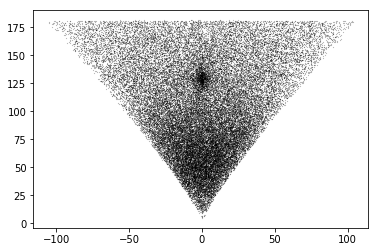

In [124]:
source = tab_source[0]
data = source.dfcart
data2 = np.copy(data)
for i in range(len(data[:,0])) :
    d = data[i,0]
    A = (255-(d-400)*0.26)/255
    data2[i,0] = data[i,0]/np.log(data[i,0])
plt.scatter(data2[:,1],data2[:,0],s=0.01,c='k')
plt.show()

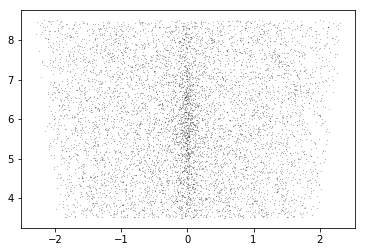

In [41]:
data = dfnormcart
ilab = np.where((data[:,0]<8.5) & (data[:,0]>3.5) & (data[:,1]<2.5) & (data[:,1]>-2.5))[0]
data = data[ilab,:]
plt.scatter(data[:,1],data[:,0],s=0.01,c='k')
plt.show()

In [27]:
c = 0
ex = 0.3

ilab = np.where((data[:,1]<c+ex) & (data[:,1]>c-ex))[0]

dist = np.sort(data[ilab,0])
distm = np.mean(dist[1:] - dist[:-1])
print(distm)

0.002547613499562922


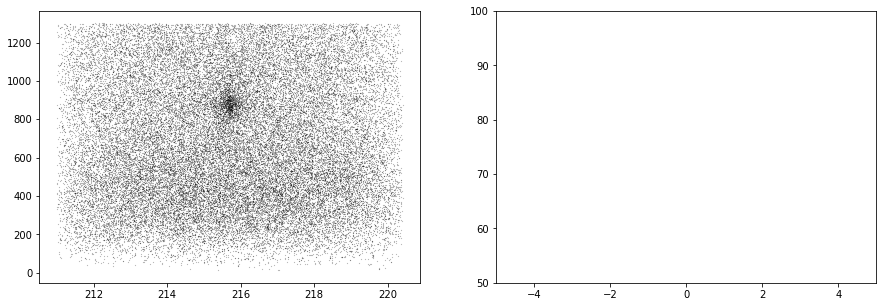

In [44]:
data = source.df
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(data[:,1],data[:,0],s=0.01,c='k')
plt.subplot(122)
plt.scatter(data[:,1],data[:,0],s=0.5,c='k')
#plt.ylim((3.5,8.5))
#plt.xlim((-2.5,2.5))
plt.ylim((50,100))
plt.xlim((-5,5))
plt.show()

## ---------------------------------------------------------------------------------------------------------------------------
## Error in the parallax and therfore in the distance

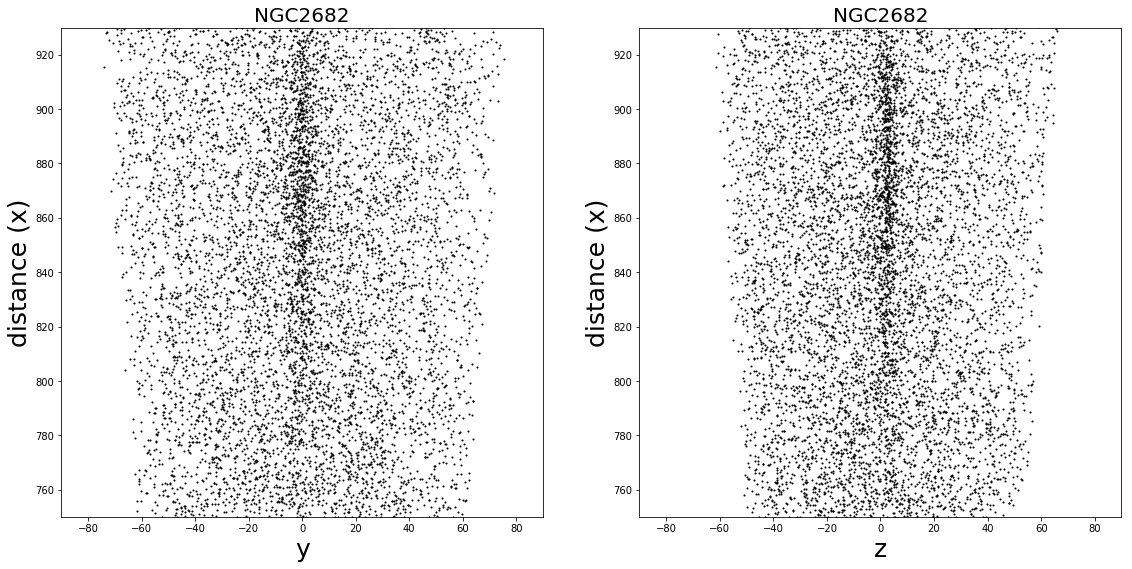

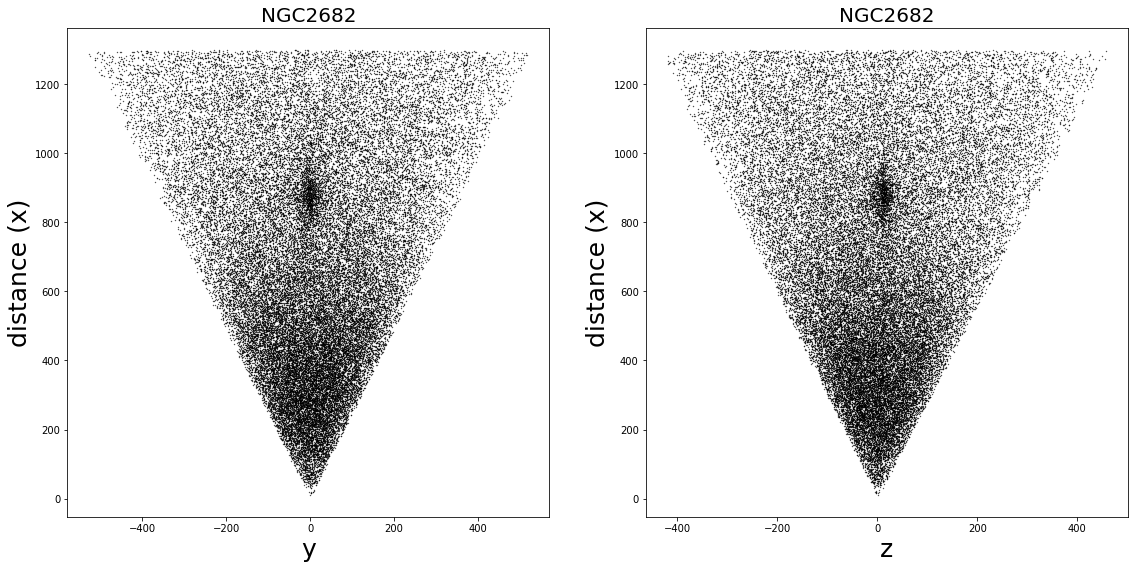

In [63]:
data = file_result[source.name]['data_cart']
#ilabel = ilabel_[0]
size = 1.1
center = 840

plt.figure(figsize=(19,9))                
for i_x, i_y, i in zip((1,2),(0,0),(1,2)) :
    plt.subplot(1,2,i)
    if i <= 2 : plt.title(source.name, fontsize=20)
    plt.scatter(source.dfcart[:,i_x],source.dfcart[:,i_y],s=size,c='k')
    #plt.scatter(data[:,i_x],data[:,i_y]/1.11260,s=size*30,c='r')
    plt.xlabel(gu.data_name_cart[i_x], fontsize=25)
    plt.ylabel(gu.data_name_cart[i_y], fontsize=25)
    plt.ylim(center-90,center+90)
    plt.xlim(-90,90)
    #plt.scatter(0,373,s=200,c='r')
plt.show()

plt.figure(figsize=(19,9))                
for i_x, i_y, i in zip((1,2),(0,0),(1,2)) :
    plt.subplot(1,2,i)
    if i <= 2 : plt.title(source.name, fontsize=20)
    plt.scatter(source.dfcart[:,i_x]*5,source.dfcart[:,i_y],s=0.1,c='k')
    #plt.scatter(data[:,i_x],data[:,i_y]/1.11260,s=size,c='w')
    plt.xlabel(gu.data_name_cart[i_x], fontsize=25)
    plt.ylabel(gu.data_name_cart[i_y], fontsize=25)
    #plt.ylim(center-60,center+60)
    #plt.xlim(-60,60)
    #plt.scatter(0,373,s=200,c='r')
plt.show()

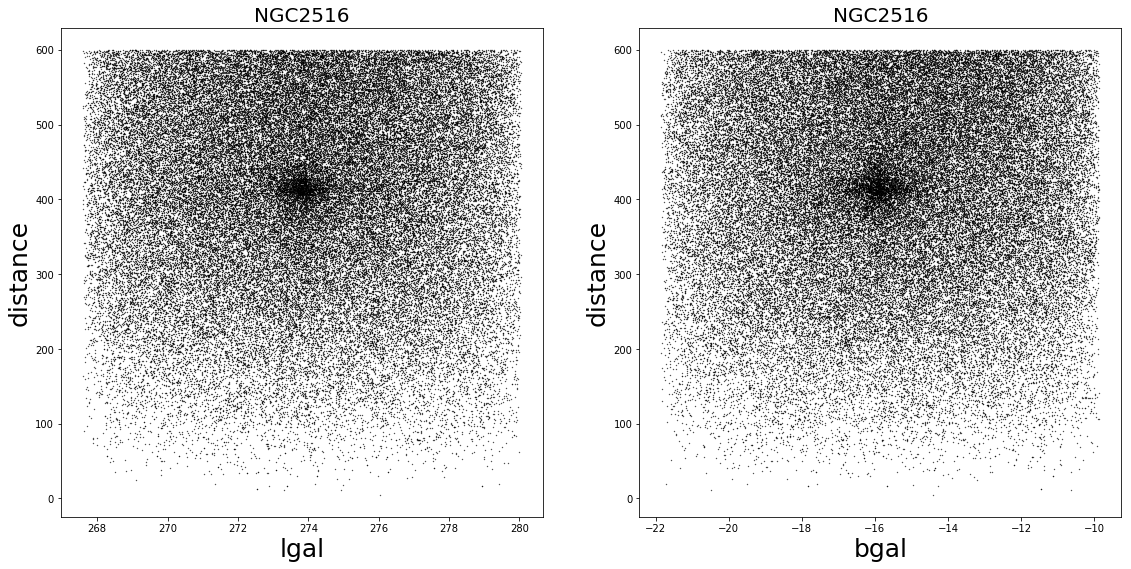

In [24]:
#ilabel = ilabel_[0]
size = 0.1

plt.figure(figsize=(19,9))                
for i_x, i_y, i in zip((1,2),(0,0),(1,2)) :
    plt.subplot(1,2,i)
    if i <= 2 : plt.title(source.name, fontsize=20)
    plt.scatter(source.df[:,i_x],source.df[:,i_y],s=size,c='k')
    #plt.scatter(source.dfcart[ilabel,i_x],source.dfcart[ilabel,i_y],s=size*300,c='r')
    plt.xlabel(gu.data_name[i_x], fontsize=25)
    plt.ylabel(gu.data_name[i_y], fontsize=25)
    #plt.ylim(350,470)
    #plt.xlim(-60,60)
plt.show()

#### ----------------------------------------------------------------------------------------------------------------

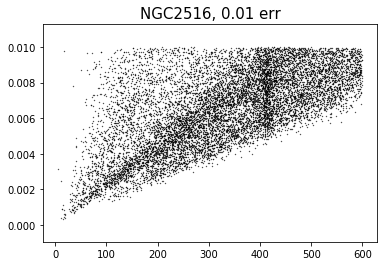

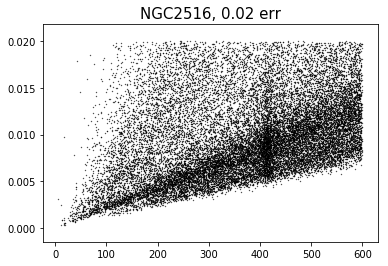

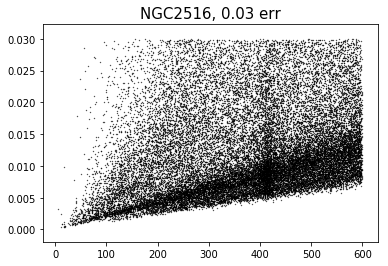

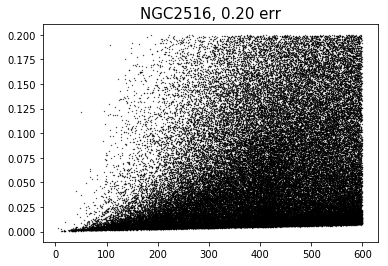

In [46]:
index = 1

for index in range(4) :

    ifinal = tab_source[index].unmasked
    parallax_err = np.array(tab_source[index].data['parallax_error'][ifinal])
    dist = tab_source[index].dfcart[:,0]
    dist_err = dist**2 * parallax_err / 1000


    #plt.scatter(dist,parallax_err/parallax,c='k',s=0.1)
    plt.title("%s, %.2f err"%(tab_source[index].name,tab_source[index].errtol),fontsize=15)
    plt.scatter(dist,dist_err/dist,c='k',s=0.1)
    #plt.yscale('log')
    plt.show()